# **Defining Expression Level Categories (ELC-analysis)**

## **Content**
### 1. ELC-analysis for barplots
### 2. ELC-analysis for PCA-s on non-normalised TPM counts
### 3. ELC-analysis for PCA-s on VS TPM counts
### 4. Calculating expression bias

In [2]:
library(data.table, warn.conflicts = FALSE)
library(RPostgreSQL)
library(foreach, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(FactoMineR, warn.conflicts = FALSE)
library(factoextra, warn.conflicts = FALSE)
library(RColorBrewer)
library(svglite)
library(cowplot, warn.conflicts = FALSE)
library(DESeq2, warn.conflicts = FALSE)

In [3]:
set.seed(42) # For reproducibility of results

In [4]:
# import count table
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
hord <- readRDS("barley_count_table_merged.rds")
h <- hord$counts
dim(h)
head(h)
# dimensions shows that a total of 193 samples were mapped to 49 281 genes of H.vulgare

[1] 49281   240

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 452.0000  388.0000  405.0000  359.0000   657.000  ⋯
Horvu_MOREX_1H01G000200   1.0000    1.0000    0.0000    0.0000     1.000  ⋯
Horvu_MOREX_1H01G000300 163.0000  160.0000  133.0000  117.0000   284.000  ⋯
Horvu_MOREX_1H01G000400 657.0000  577.0000  605.0000  540.0000  1183.000  ⋯
Horvu_MOREX_1H01G000500 635.0000  772.0000  607.0000  630.0000  1166.000  ⋯
Horvu_MOREX_1H01G000600 776.8168  827.0809  874.5452  566.1862  1397.799  ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 1232.000  2237.000  1503.000  1833.000  1695.000 
Horvu_MOREX_1H01G000200    1.000     3.000    10.000     1.000     2.000 
Horvu_MOREX_1H01G000300  428.000   610.000   519.000   466.000   492.000 
Horvu_MOREX_1H01G000400  971.000  1640.000  1312.000  1160.000  2093.000 
Horvu_MOREX_1H01G000500 3656.000  4336.000  4734.000  4469.000  2296.000 
Horvu_MOREX_1H01G000600 2808.661  3316.393  2766.549  2833.275  2984.255 
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 2477.000  2265.000  2578.000  2468.000  2317.000 
Horvu_MOREX_1H01G000200    8.000     6.000     0.000     2.000     2.000 
Horvu_MOREX_1H01G000300  652.000   569.000   677.000   710.000   584.000 
Horvu_MOREX_1H01G000400 2738.000  2795.000  3687.000  3044.000  3045.000 
Horvu_MOREX_1H01G000500 2418.000  2349.000  3908.000  3340.000  3221.000 
Horvu_MOREX_1H01G000600 4250.868  3915.629  4172.974  4106.843  4045.146

In [5]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
barley_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = TRUE)
barley_meta <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# add rownames for deseq2 to identify rows with count-columns
rownames(barley_meta) <- barley_meta$ID
glimpse(barley_meta)
tail(barley_meta)

Rows: 240
Columns: 22
$ ID                  <fct> ERR781039, ERR781040, ERR781041, ERR781042, ERR78…
$ dataset             <fct> photoperiod_mutant_preanthesis, photoperiod_mutan…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6…
$ cultivar            <fct> S42-IL107, S42-IL107, S42-IL107, Scarlett, Scarle…
$ gm                  <fct> wt, wt, wt, mut, mut, mut, wt, wt, wt, wt, wt, wt…
$ zadoc_scale         <int> 9, 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, …
$ intermediate_age    <fct> Germination, Germination, Germination, Leaf_devel…
$ high_level_age      <fct> Seedling, Seedling, Seedling, Vegetative, Vegetat…
$ intermediate_tissue <fct> apex, apex, apex, apex, apex, apex, apex, apex, a…
$ high_level_tissue   <fct> meristem, meristem, meristem, meristem, meristem,…
$ treatment           <fct> control, control, control, mutant, mutant, mutant…
$ rna_extraction      <fct> trizol, trizol, trizol, trizol, trizol, trizol, t…
$ rna_enrichment      <fct> Rn

ID        dataset        batch cultivar gm  zadoc_scale
ERR515192 ERR515192 laxatum_mutant 75    Bowman   wt  31         
ERR515193 ERR515193 laxatum_mutant 75    Bowman   wt  31         
ERR515194 ERR515194 laxatum_mutant 75    Bowman   wt  31         
ERR515195 ERR515195 laxatum_mutant 76    Bowman   mut 31         
ERR515196 ERR515196 laxatum_mutant 76    Bowman   mut 31         
ERR515197 ERR515197 laxatum_mutant 76    Bowman   mut 31         
          intermediate_age high_level_age intermediate_tissue high_level_tissue
ERR515192 Stem_elongation  Reproductive   spike               inflorescence    
ERR515193 Stem_elongation  Reproductive   spike               inflorescence    
ERR515194 Stem_elongation  Reproductive   spike               inflorescence    
ERR515195 Stem_elongation  Reproductive   spike               inflorescence    
ERR515196 Stem_elongation  Reproductive   spike               inflorescence    
ERR515197 Stem_elongation  Reproductive   spike               inflorescence    
          ⋯ rna_enrichment rna_input pcr_purification growth_condition
ERR515192 ⋯ unknown        unknown   unknown          unknown         
ERR515193 ⋯ unknown        unknown   unknown          unknown         
ERR515194 ⋯ unknown        unknown   unknown          unknown         
ERR515195 ⋯ unknown        unknown   unknown          unknown         
ERR515196 ⋯ unknown        unknown   unknown          unknown         
ERR515197 ⋯ unknown        unknown   unknown          unknown         
          day_night temp    growth_location     seq_location       
ERR515192 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515193 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515194 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515195 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515196 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515197 unknown   unknown Germany_Gatersleben Germany_Gatersleben
          instrument          library
ERR515192 Illumina HiSeq 2000 paired 
ERR515193 Illumina HiSeq 2000 paired 
ERR515194 Illumina HiSeq 2000 paired 
ERR515195 Illumina HiSeq 2000 paired 
ERR515196 Illumina HiSeq 2000 paired 
ERR515197 Illumina HiSeq 2000 paired

# 1. ELC-analysis for barplots

In [6]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=h
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
h_elc=apply(h,2,get_elc,non.expr.cutoff)
colnames(h_elc)=colnames(h)
rownames(h_elc)=rownames(h)
head(h_elc)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000200 E1        E0        E0        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E3        E3        E4        E4       
Horvu_MOREX_1H01G000500 E4        E3        E3        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 E3        E3        E3        E3        E3        ⋯
Horvu_MOREX_1H01G000200 E1        E1        E0        E0        E1        ⋯
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3        ⋯
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4        ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E1        E1        E1        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E1        E1        E0        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4

In [7]:
elc_df <- as.data.frame(h_elc, stringsAsFactors = FALSE)
elc_df <- pivot_longer(elc_df, cols = c(1:240), names_to = "sample", values_to = "ELC")
glimpse(elc_df)

Rows: 11,827,440
Columns: 2
$ sample <chr> "ERR781039", "ERR781040", "ERR781041", "ERR781042", "ERR781043…
$ ELC    <chr> "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E…


In [8]:
barley_meta_elc <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta_elc) <- c("sample", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

elc <- elc_df %>% select(sample, ELC) %>%
                dplyr::group_by(sample) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))

elc_0 <- elc %>% select(sample, E0, E1, E2, E3, E4) %>%
                pivot_longer(-sample, names_to = "ELC", values_to = "ELC_value")

elc_meta <- inner_join(barley_meta_elc, elc_0, by = "sample")
glimpse(elc)
glimpse(elc_0)
glimpse(elc_meta)

Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”

Rows: 240
Columns: 7
$ sample <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR1248087", "ERR12…
$ total  <int> 49281, 49281, 49281, 49281, 49281, 49281, 49281, 49281, 49281,…
$ E0     <int> 22318, 19781, 21225, 20287, 23226, 21089, 26194, 23532, 24795,…
$ E1     <int> 5606, 6678, 6329, 6725, 6281, 6544, 5189, 6404, 5648, 5736, 54…
$ E2     <int> 6246, 6782, 6569, 6676, 5524, 6343, 5467, 6046, 5775, 5775, 59…
$ E3     <int> 8262, 8587, 8556, 8582, 7431, 8206, 7153, 7651, 7620, 7410, 78…
$ E4     <int> 6849, 7453, 6602, 7011, 6819, 7099, 5278, 5648, 5443, 5847, 54…
Rows: 1,200
Columns: 3
$ sample    <chr> "ERR1248084", "ERR1248084", "ERR1248084", "ERR1248084", "ER…
$ ELC       <chr> "E0", "E1", "E2", "E3", "E4", "E0", "E1", "E2", "E3", "E4",…
$ ELC_value <int> 22318, 5606, 6246, 8262, 6849, 19781, 6678, 6782, 8587, 745…
Rows: 1,200
Columns: 24
$ sample              <chr> "ERR781039", "ERR781039", "ERR781039", "ERR781039…
$ dataset             <fct> photoperiod_mutant_preanthesis, pho

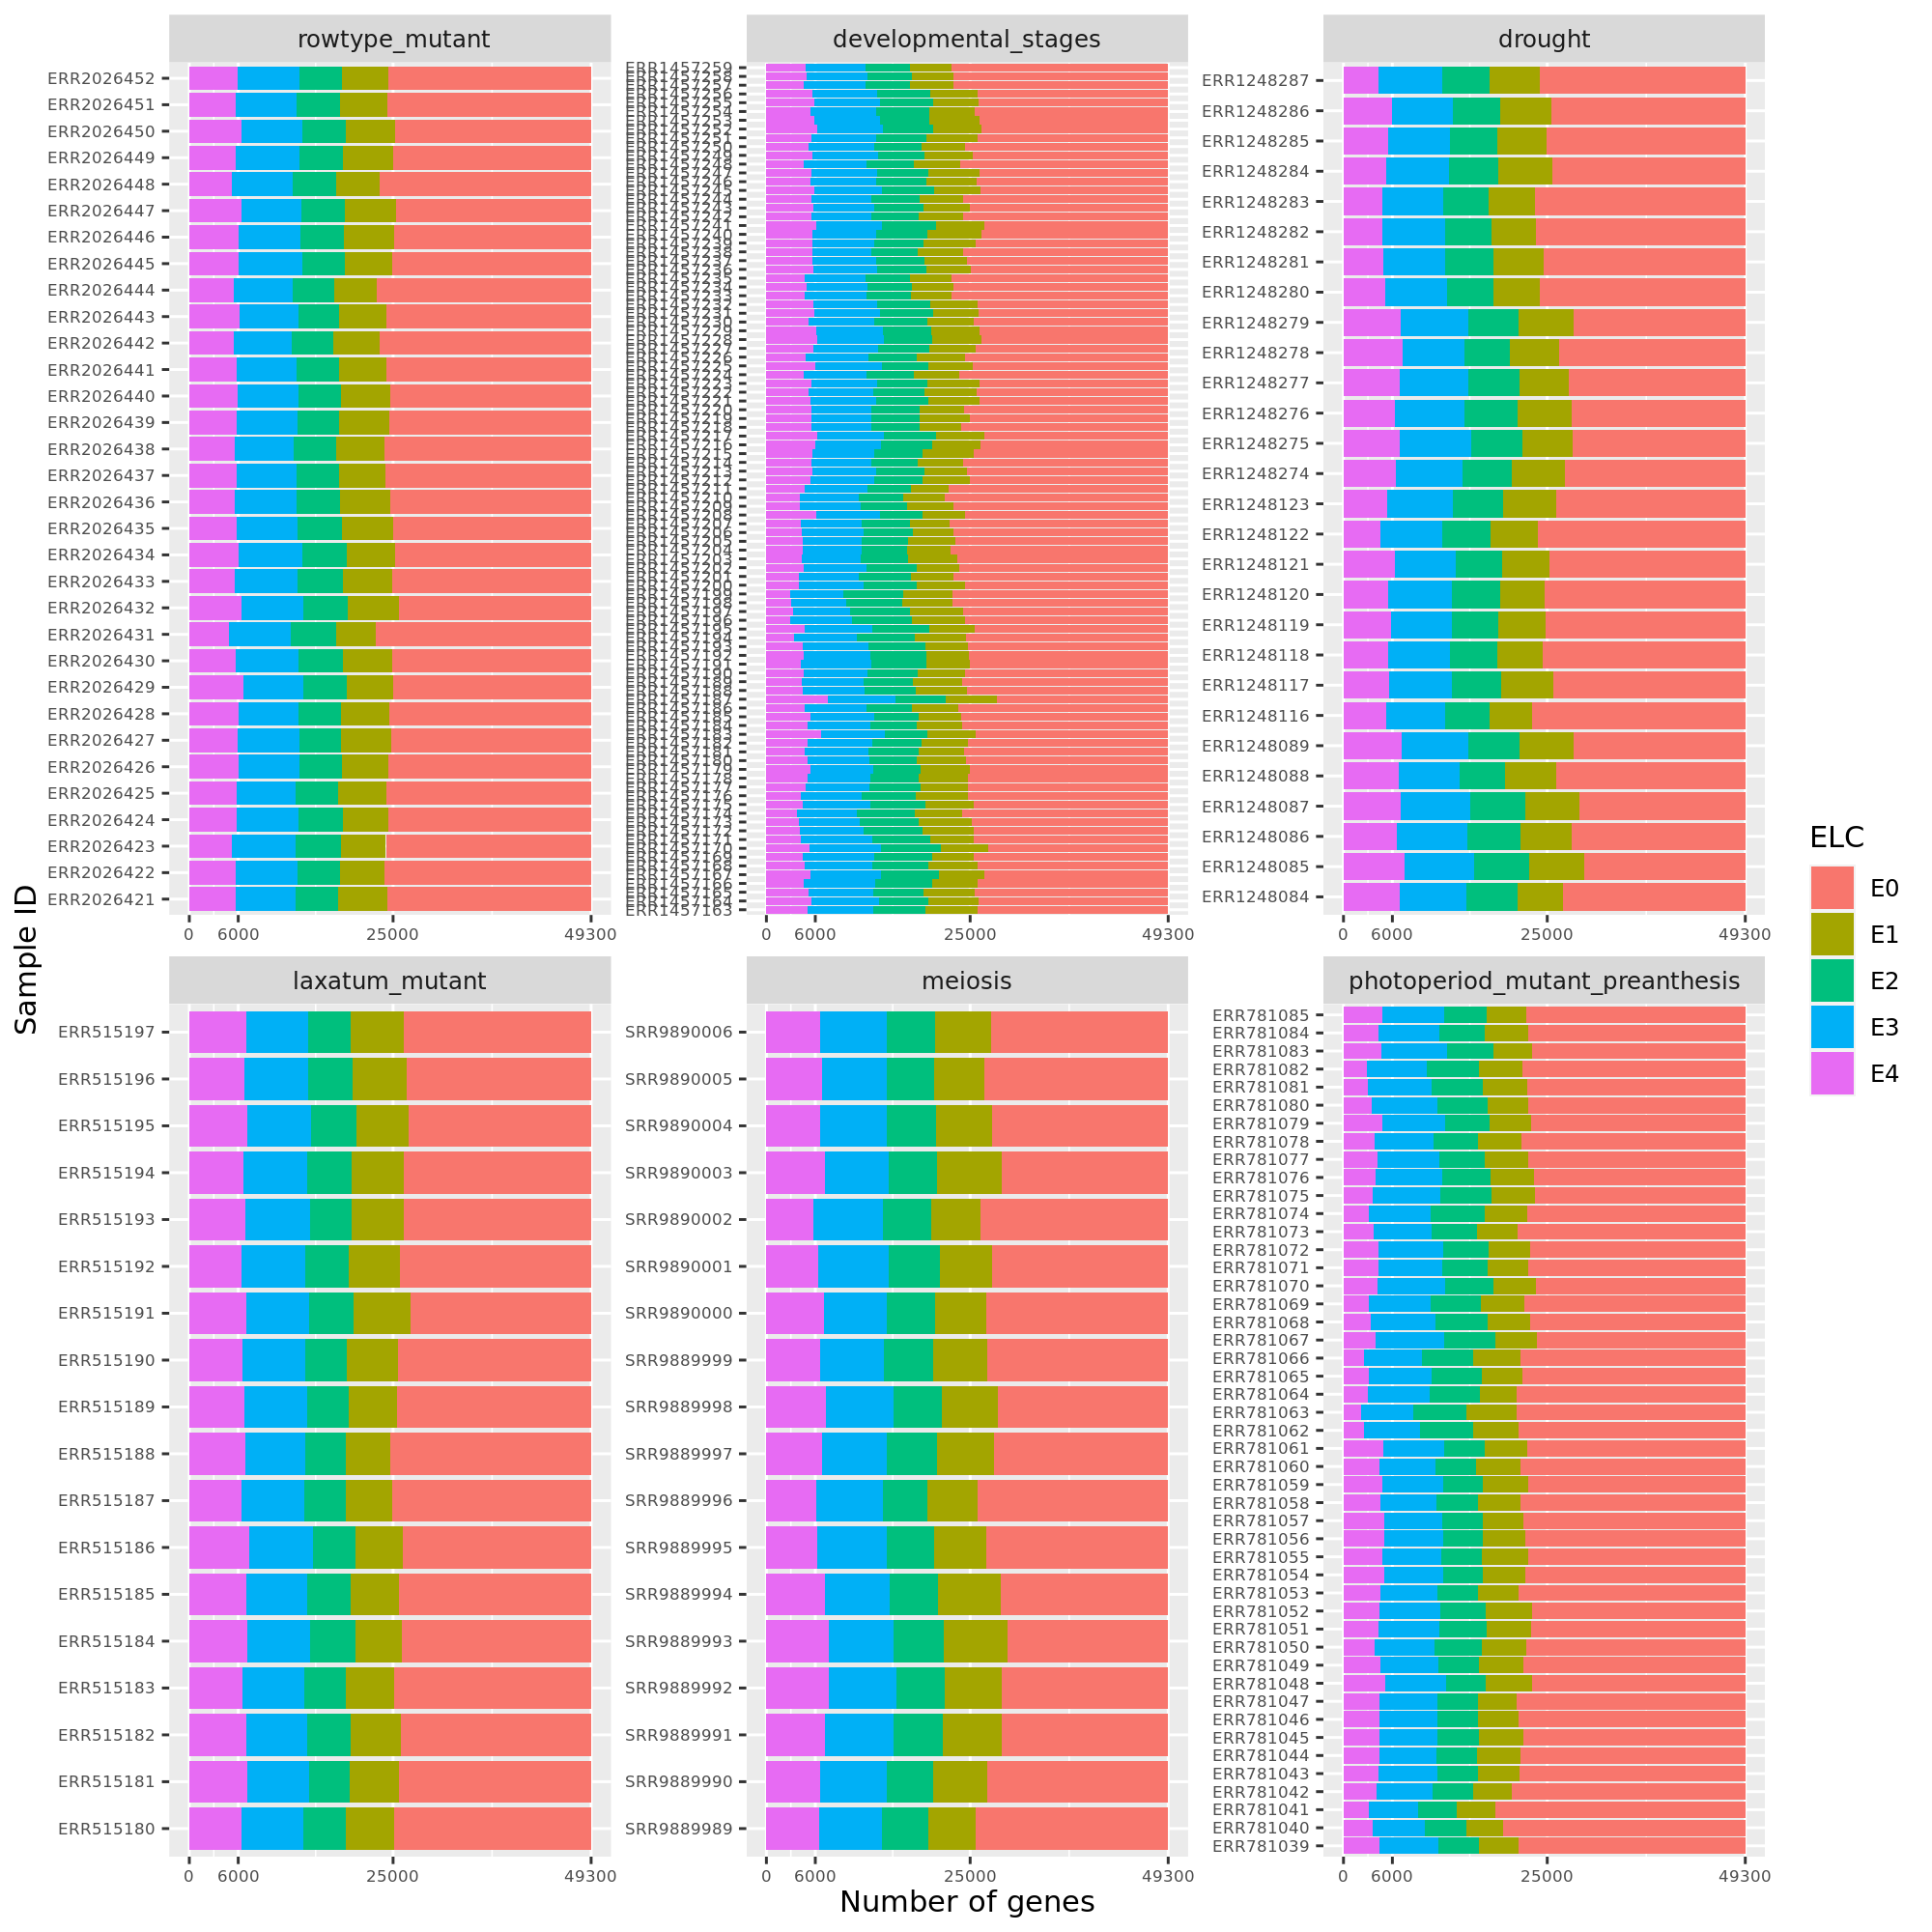

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
# reverse = TRUE add to geom_col
elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ dataset, scales= "free", ncol = 3) +
        theme(axis.text = element_text(size=6))

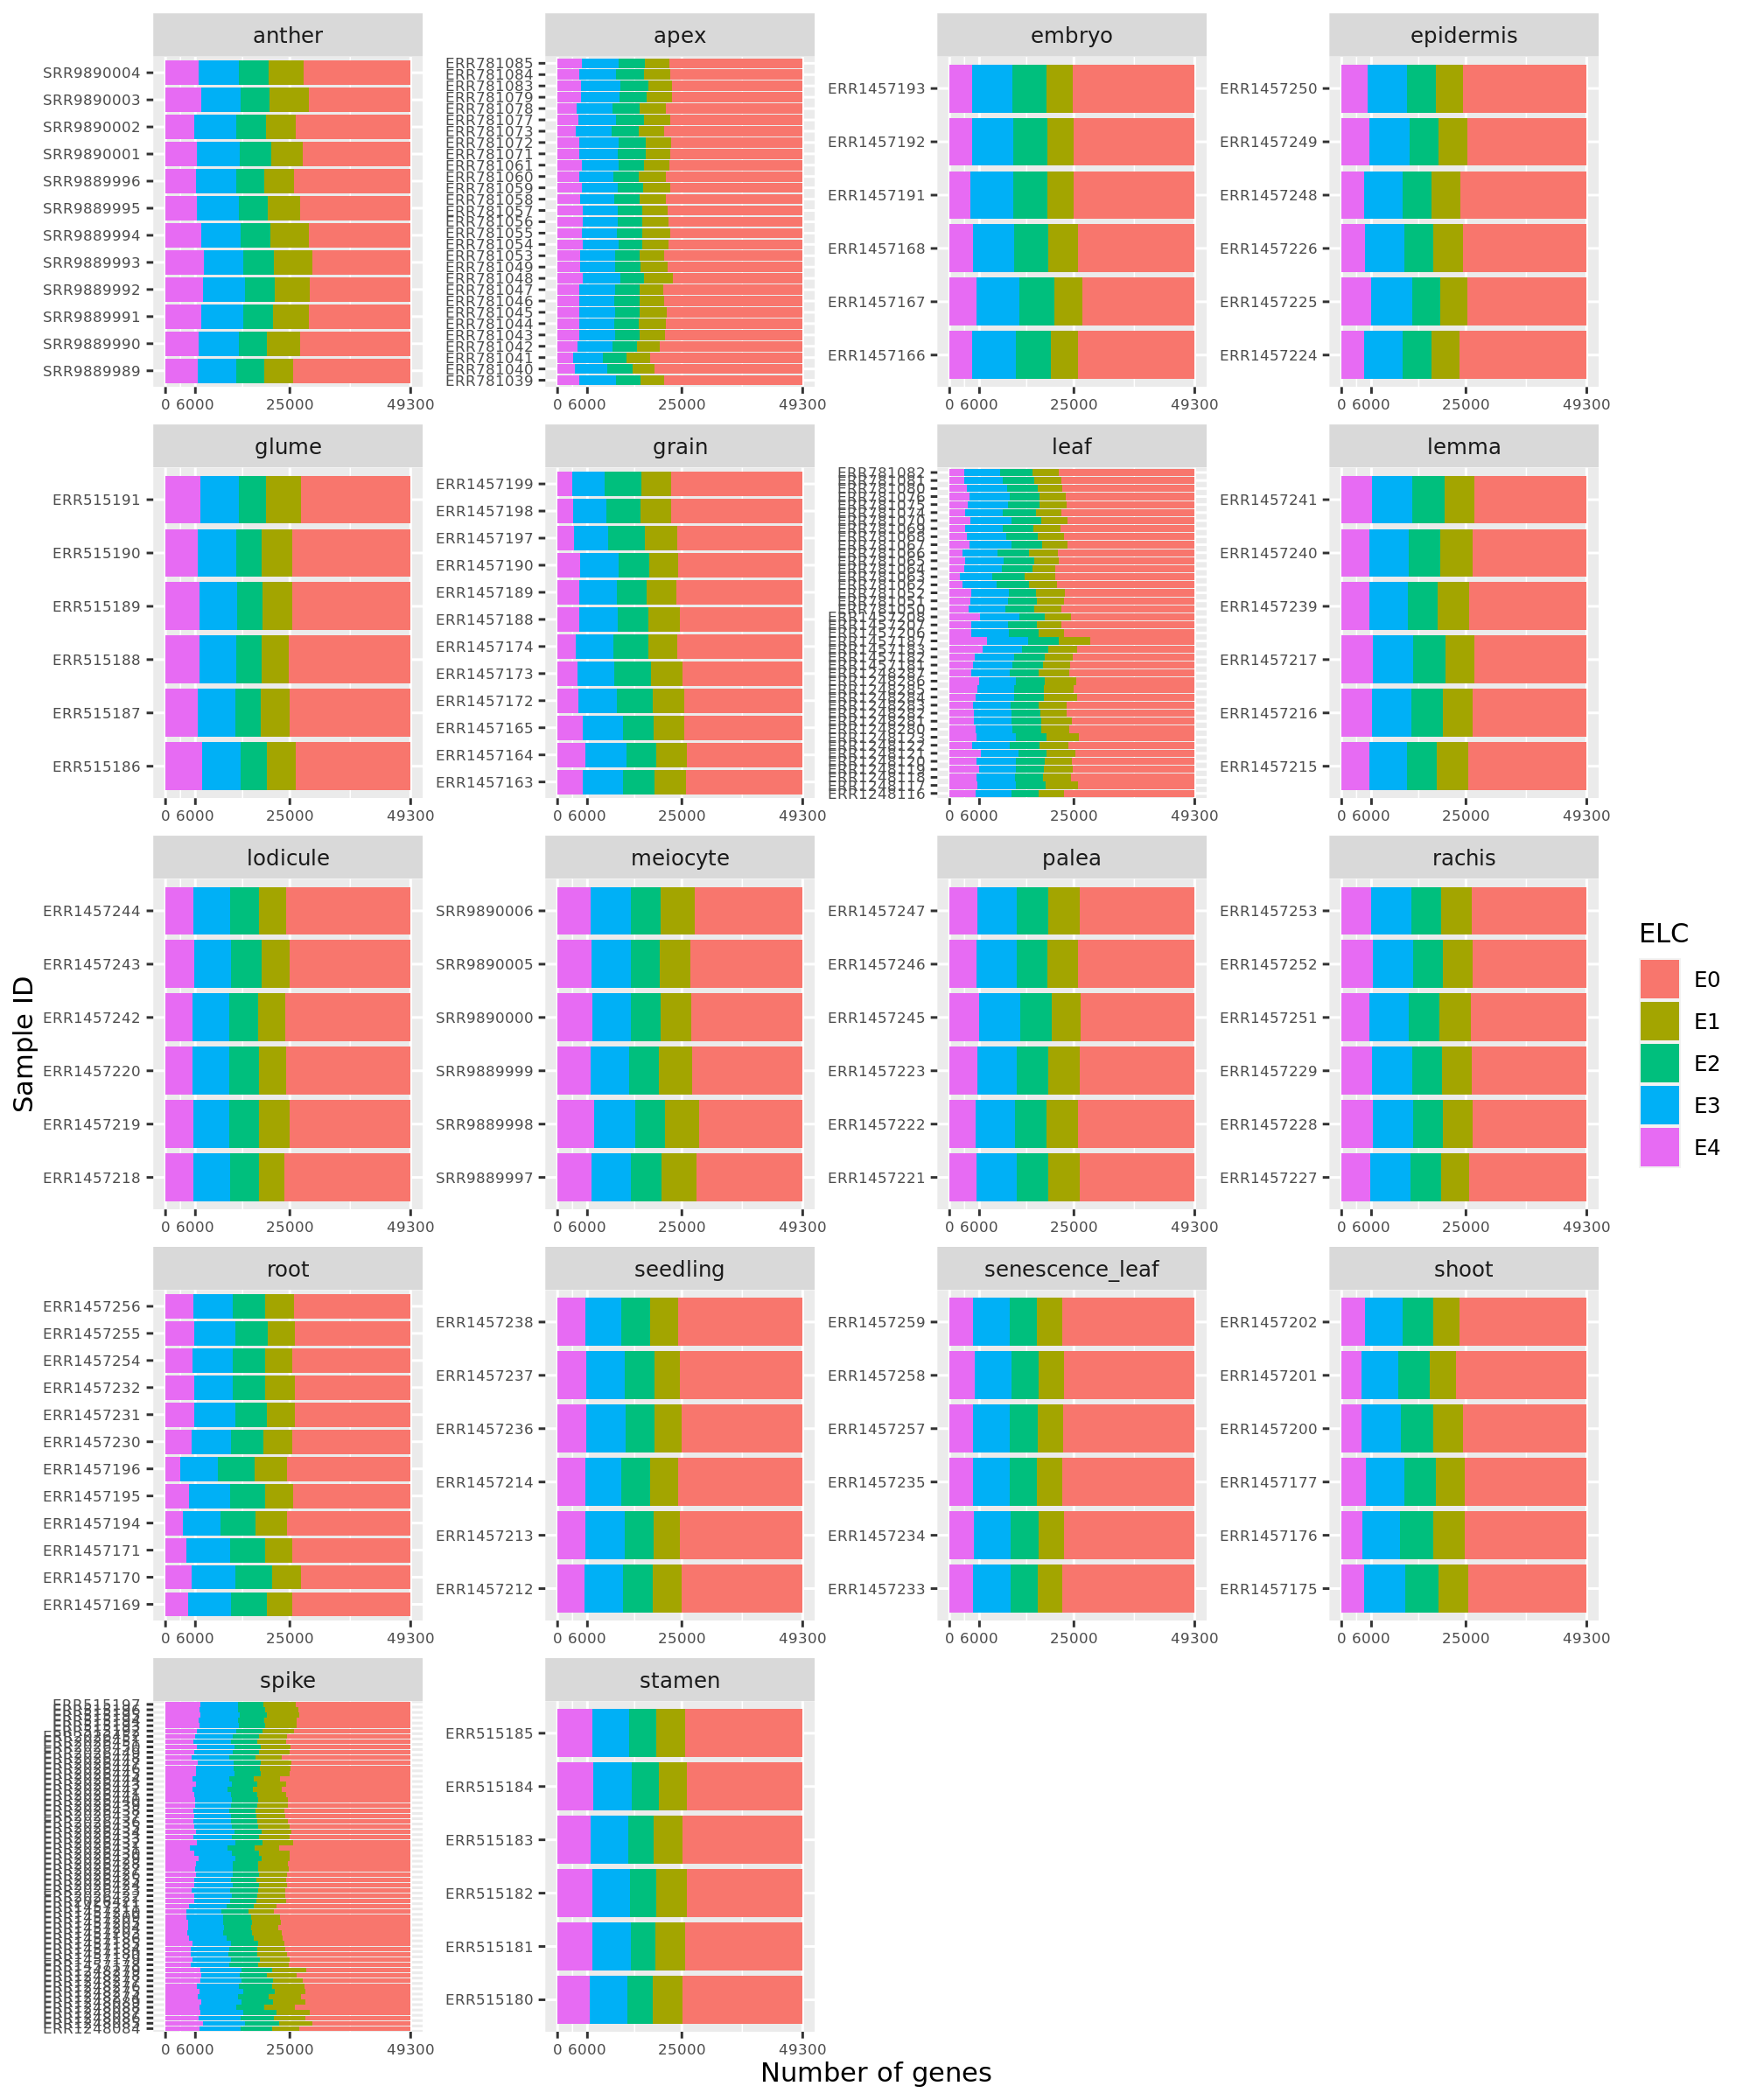

In [10]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 200)

elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ intermediate_tissue, scales= "free", ncol = 4) +
        theme(axis.text = element_text(size=6))

# 2. ELC-analysis for PCA-s on non-normalised TPM counts


In [11]:
elc_pca <- elc %>% transmute(sample = sample, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
elc_pca_meta <- inner_join(elc_pca, barley_meta_elc, by = "sample")
elc_pca_meta <- as.data.frame(elc_pca_meta, stringsAsFactors = TRUE)
rownames(elc_pca_meta) <- elc_pca_meta$sample
elc_pca_meta <- select(elc_pca_meta, -sample)
head(elc_pca_meta)

Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”

E0        E1        E2        E3        E4        dataset batch
ERR1248084 0.4528723 0.1137558 0.1267426 0.1676508 0.1389785 drought 17   
ERR1248085 0.4013920 0.1355086 0.1376190 0.1742457 0.1512348 drought 17   
ERR1248086 0.4306934 0.1284268 0.1332968 0.1736166 0.1339664 drought 18   
ERR1248087 0.4116597 0.1364623 0.1354680 0.1741442 0.1422658 drought 18   
ERR1248088 0.4712973 0.1274528 0.1120919 0.1507883 0.1383698 drought 19   
ERR1248089 0.4279337 0.1327895 0.1287109 0.1665145 0.1440515 drought 19   
           cultivar gm zadoc_scale ⋯ rna_enrichment rna_input pcr_purification
ERR1248084 Scarlett wt 37          ⋯ unknown        unknown   unknown         
ERR1248085 Scarlett wt 37          ⋯ unknown        unknown   unknown         
ERR1248086 Scarlett wt 37          ⋯ unknown        unknown   unknown         
ERR1248087 Scarlett wt 37          ⋯ unknown        unknown   unknown         
ERR1248088 Scarlett wt 37          ⋯ unknown        unknown   unknown         
ERR1248089 Scarlett wt 37          ⋯ unknown        unknown   unknown         
           growth_condition day_night  temp       growth_location seq_location
ERR1248084 incubator        controlled controlled Spain           Spain       
ERR1248085 incubator        controlled controlled Spain           Spain       
ERR1248086 incubator        controlled controlled Spain           Spain       
ERR1248087 incubator        controlled controlled Spain           Spain       
ERR1248088 incubator        controlled controlled Spain           Spain       
ERR1248089 incubator        controlled controlled Spain           Spain       
           instrument          library
ERR1248084 Illumina HiSeq 2000 paired 
ERR1248085 Illumina HiSeq 2000 paired 
ERR1248086 Illumina HiSeq 2000 paired 
ERR1248087 Illumina HiSeq 2000 paired 
ERR1248088 Illumina HiSeq 2000 paired 
ERR1248089 Illumina HiSeq 2000 paired

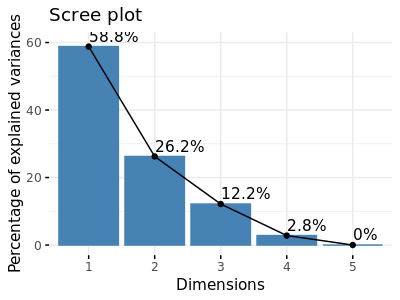

In [12]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)

elc_pca <- PCA(elc_pca_meta,quali.sup=6:26,graph=F)
fviz_screeplot(elc_pca, addlabels = TRUE, ylim = c(0, 60))

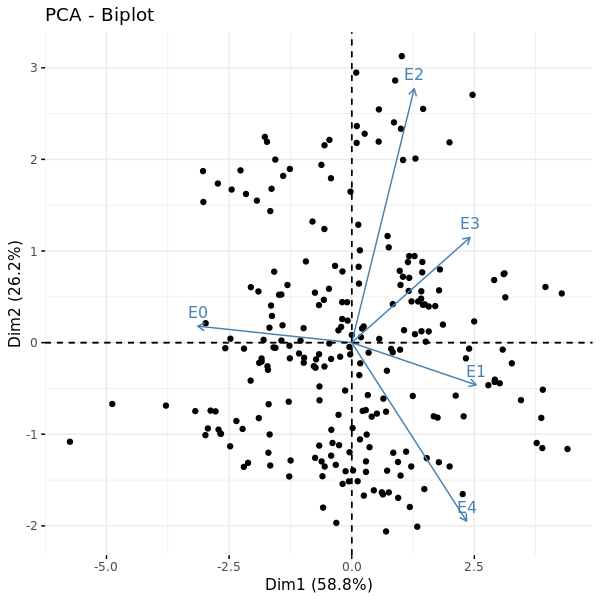

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(elc_pca, repel = FALSE,geom="point")

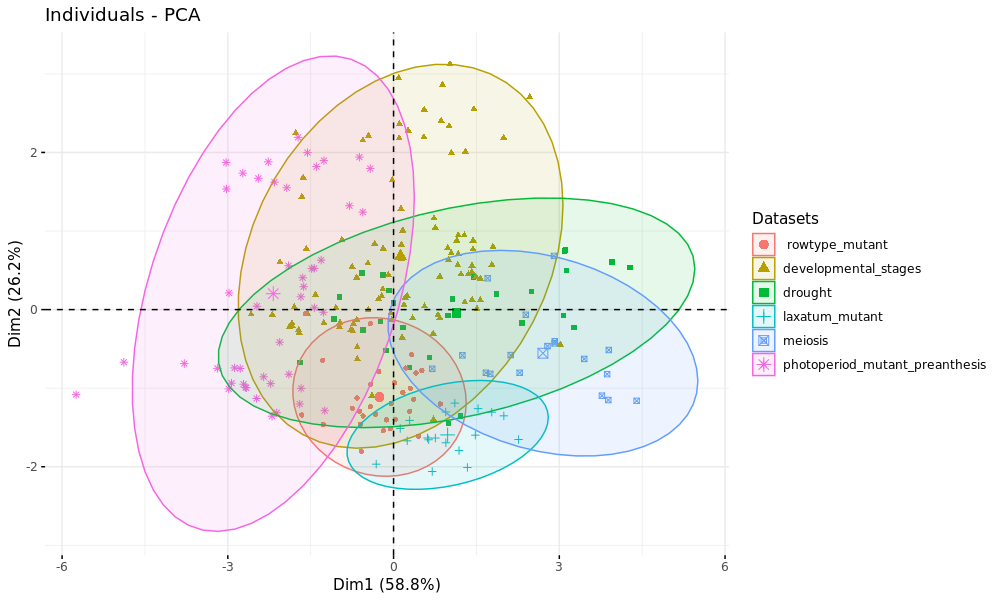

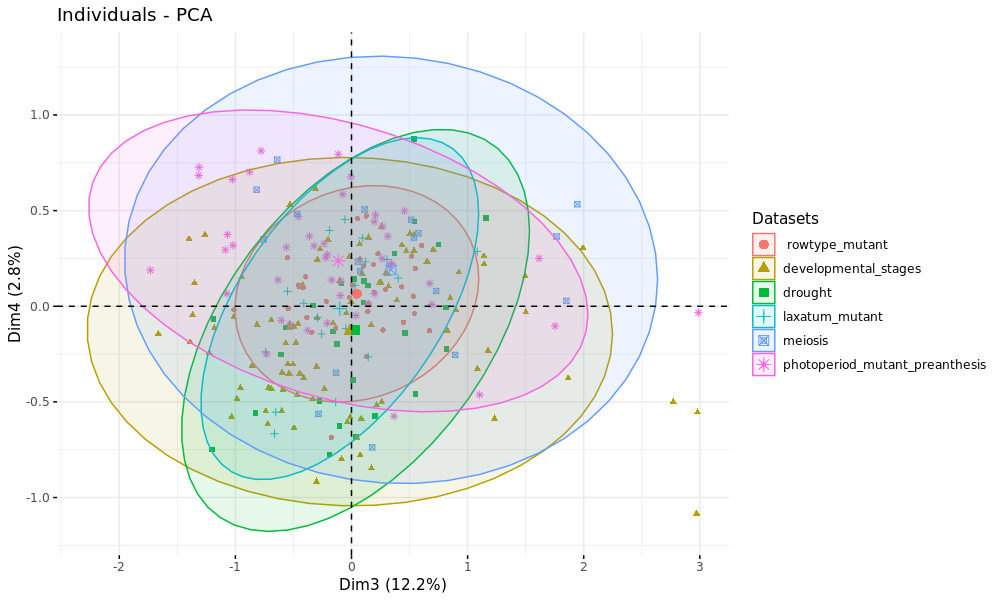

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [15]:
# build comparism plot variables
b1 <- fviz_pca_ind(X = elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = elc_pca_meta$dataset)
b2 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = elc_pca_meta$library)
b3 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = elc_pca_meta$instrument)
b4 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = elc_pca_meta$high_level_tissue)
b5 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = elc_pca_meta$high_level_age)
b6 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Intermediate tissue", habillage = elc_pca_meta$intermediate_tissue)

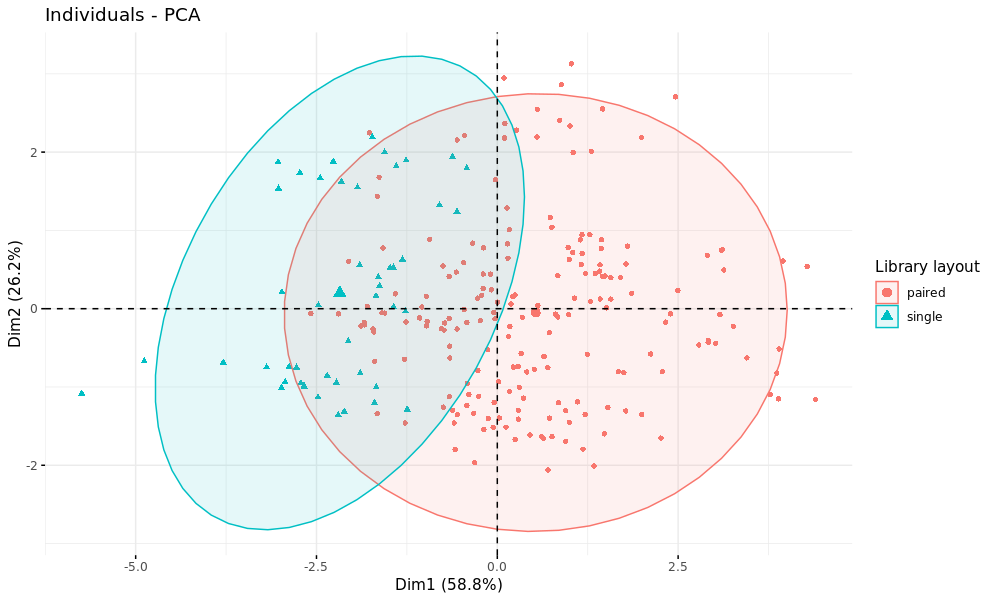

In [16]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

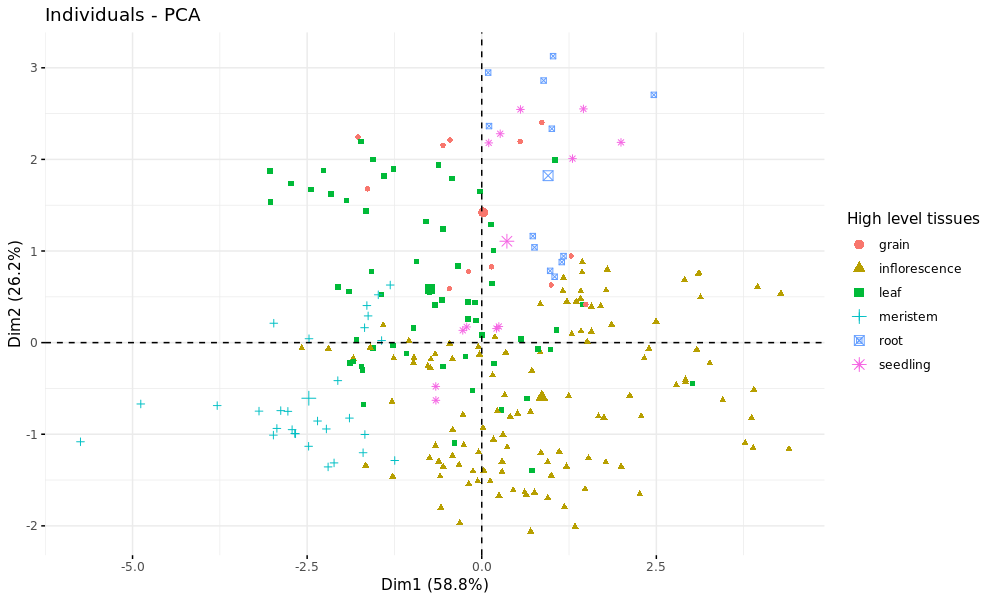

In [17]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

Dim.1     Dim.2       Dim.3        Dim.4       Dim.5       
E0 0.9915354 0.003256842 3.153607e-06 0.005204599 2.519552e-30
E1 0.6470456 0.021431860 3.021800e-01 0.029342529 2.324387e-31
E2 0.1632293 0.772487864 2.960098e-02 0.034681823 2.433489e-31
E3 0.5858005 0.132716136 2.445397e-01 0.036943718 1.386209e-31
E4 0.5523293 0.382001177 3.127833e-02 0.034391233 9.088246e-31

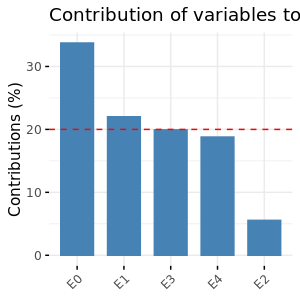

In [18]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(elc_pca)$cos2
fviz_contrib(elc_pca,"var",top=20,axis=1)

# 3. ELC-analysis for PCA-s on VS TPM counts


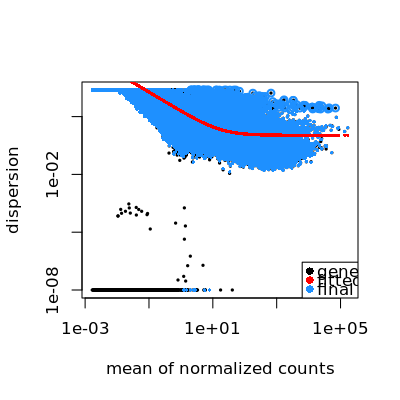

In [20]:
# import dds object from DESeq2 notebook
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
dds_barley <- readRDS(file="dds_barley.rds")
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 100)
plotDispEsts(dds_barley)

In [21]:
# this function gives log2 to raw counts
vsd_barley <- varianceStabilizingTransformation(dds_barley)
# this function returns matrix with log2transformed counts
vsdMat_barley <- assay(vsd_barley)

In [22]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=vsdMat_barley
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
vs_elc=apply(vsdMat_barley,2,get_elc,non.expr.cutoff)
colnames(vs_elc)=colnames(vsdMat_barley)
rownames(vs_elc)=rownames(vsdMat_barley)
head(vs_elc)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E1        E1        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000200 E2        E2        E1        E1        E2        ⋯
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4        ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E2        E2        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E2        E1        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4

In [23]:
colnames(barley_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

vs_df <- as.data.frame(vs_elc, stringsAsFactors = FALSE)
vs_df <- pivot_longer(vs_df, cols = c(1:240), names_to = "ID", values_to = "ELC")

elc_vs <- vs_df %>% select(ID, ELC) %>%
                dplyr::group_by(ID) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))
vs_elc_pca <- elc_vs %>% transmute(ID = ID, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
vs_elc_pca_meta <- inner_join(vs_elc_pca, barley_meta, by = "ID")
vs_elc_pca_meta <- as.data.frame(vs_elc_pca_meta, stringsAsFactors = TRUE)
rownames(vs_elc_pca_meta) <- vs_elc_pca_meta$ID
vs_elc_pca_meta <- select(vs_elc_pca_meta, -ID)
head(vs_elc_pca_meta)
dim(vs_elc_pca_meta)

Warning message:
“Column `ID` joining character vector and factor, coercing into character vector”

E0 E1        E2        E3        E4        dataset batch cultivar gm
ERR1248084 0  0.3692690 0.1411043 0.1740973 0.3155294 drought 17    Scarlett wt
ERR1248085 0  0.3108697 0.1686882 0.1830188 0.3374233 drought 17    Scarlett wt
ERR1248086 0  0.3434880 0.1504238 0.1789444 0.3271437 drought 18    Scarlett wt
ERR1248087 0  0.3214537 0.1650588 0.1829954 0.3304922 drought 18    Scarlett wt
ERR1248088 0  0.3901091 0.1529762 0.1562076 0.3007072 drought 19    Scarlett wt
ERR1248089 0  0.3403269 0.1595560 0.1704210 0.3296961 drought 19    Scarlett wt
           zadoc_scale ⋯ rna_enrichment rna_input pcr_purification
ERR1248084 37          ⋯ unknown        unknown   unknown         
ERR1248085 37          ⋯ unknown        unknown   unknown         
ERR1248086 37          ⋯ unknown        unknown   unknown         
ERR1248087 37          ⋯ unknown        unknown   unknown         
ERR1248088 37          ⋯ unknown        unknown   unknown         
ERR1248089 37          ⋯ unknown        unknown   unknown         
           growth_condition day_night  temp       growth_location seq_location
ERR1248084 incubator        controlled controlled Spain           Spain       
ERR1248085 incubator        controlled controlled Spain           Spain       
ERR1248086 incubator        controlled controlled Spain           Spain       
ERR1248087 incubator        controlled controlled Spain           Spain       
ERR1248088 incubator        controlled controlled Spain           Spain       
ERR1248089 incubator        controlled controlled Spain           Spain       
           instrument          library
ERR1248084 Illumina HiSeq 2000 paired 
ERR1248085 Illumina HiSeq 2000 paired 
ERR1248086 Illumina HiSeq 2000 paired 
ERR1248087 Illumina HiSeq 2000 paired 
ERR1248088 Illumina HiSeq 2000 paired 
ERR1248089 Illumina HiSeq 2000 paired

[1] 240  26

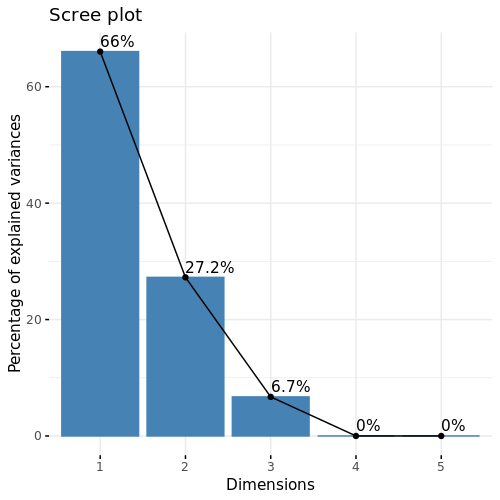

In [24]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

vs_elc_pca <- PCA(vs_elc_pca_meta,quali.sup=c(6:26),graph=F)
fviz_screeplot(vs_elc_pca, addlabels = TRUE)

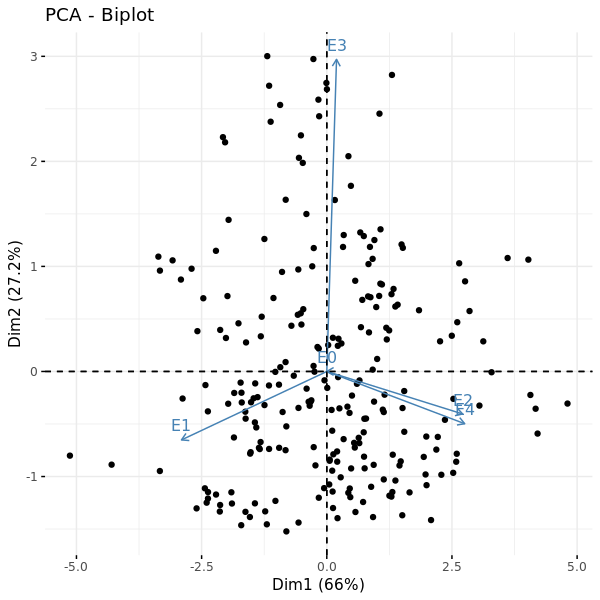

In [25]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(vs_elc_pca, repel = FALSE,geom="point")

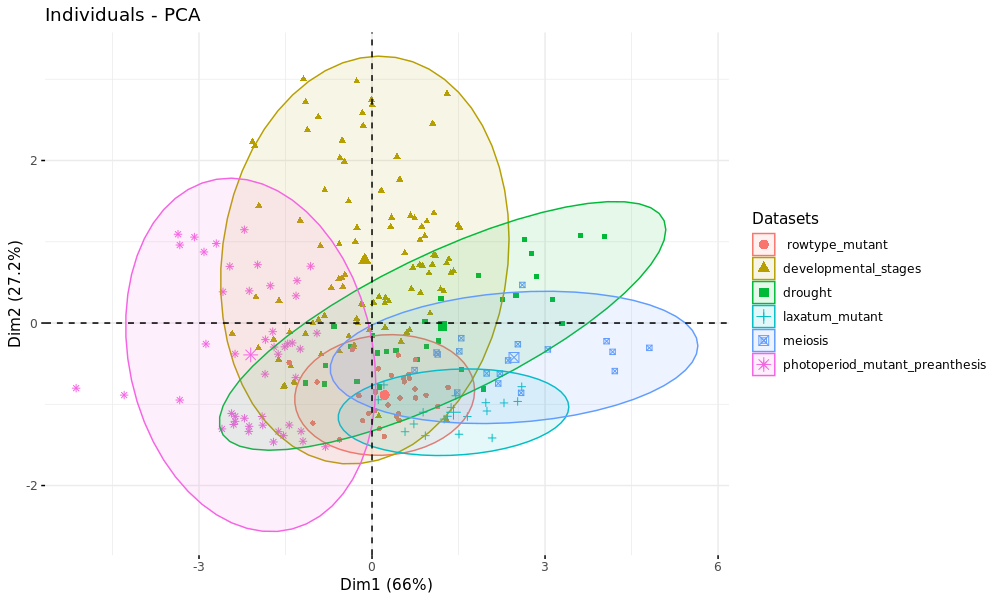

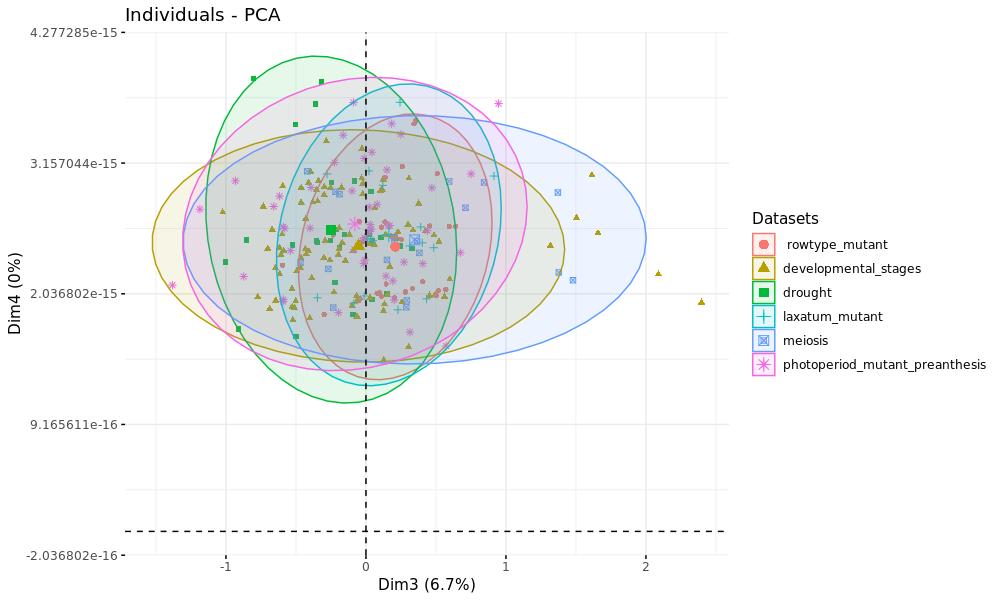

In [26]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [27]:
# build comparism plot variables
d1 <- fviz_pca_ind(X = vs_elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = vs_elc_pca_meta$dataset)
d2 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = vs_elc_pca_meta$library)
d3 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = vs_elc_pca_meta$instrument)
d4 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = vs_elc_pca_meta$high_level_tissue)
d5 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = vs_elc_pca_meta$high_level_age)
d6 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Intermediate tissue", habillage = vs_elc_pca_meta$intermediate_tissue)

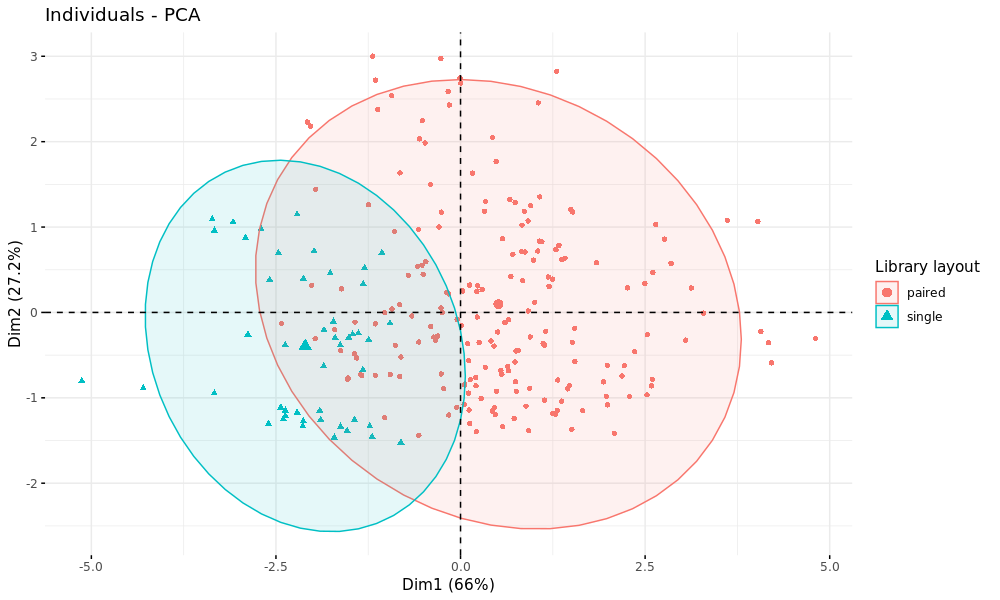

In [28]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

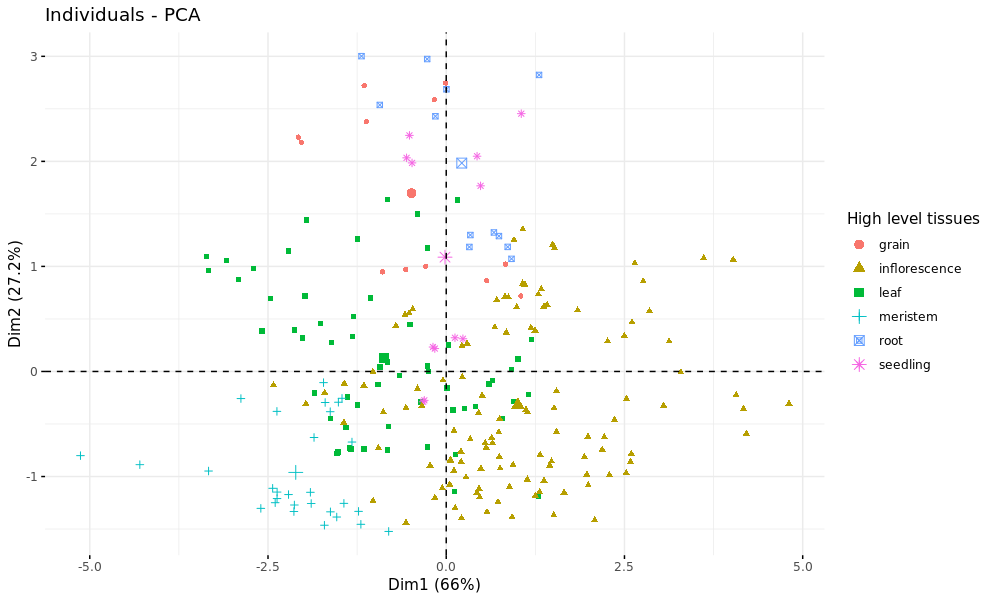

In [29]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

Dim.1       Dim.2      Dim.3        Dim.4        Dim.5
E0         NaN        NaN          NaN          NaN NaN  
E1 0.950448451 0.04787586 1.675686e-03 3.840088e-30   0  
E2 0.830388055 0.01847094 1.511410e-01 6.880508e-31   0  
E3 0.004268326 0.99570690 2.477085e-05 5.518083e-31   0  
E4 0.856445590 0.02792932 1.156251e-01 1.428370e-30   0

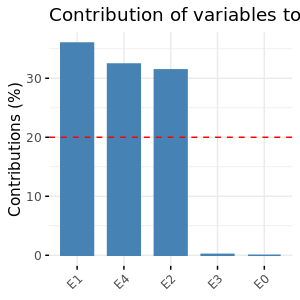

In [30]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(vs_elc_pca)$cos2
fviz_contrib(vs_elc_pca,"var",top=20,axis=1)

## 3.1 Summarizing comparism figures

In [31]:
# figure about why variance stabilization is necessary
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)

prow1 <- plot_grid(b1 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d1 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend1 <- get_legend(b1 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow2 <- plot_grid(b2 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d2 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend2 <- get_legend(b2 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow3 <- plot_grid(b3 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d3 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend3 <- get_legend(b3 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow4 <- plot_grid(b4 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d4 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend4 <- get_legend(b4 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow5 <- plot_grid(b5 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d5 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend5 <- get_legend(b5 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow6 <- plot_grid(b6 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d6 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend6 <- get_legend(b6 + theme(legend.box.margin = margin(0, 0, 0, 12), legend.position = "bottom"))
# to save as a png
#png("stabilized_counts.png", units="in", width=10, height=4, res=300)
#cowplot::plot_grid(p1$gg + ggtitle("TPM") + scale_x_continuous(breaks =c(0, 25000, 75000, 125000)), p2$gg + ggtitle("log10(TPM)"), p3$gg + ggtitle("Variance Stabilized counts"), ncol = 3)
#dev.off()

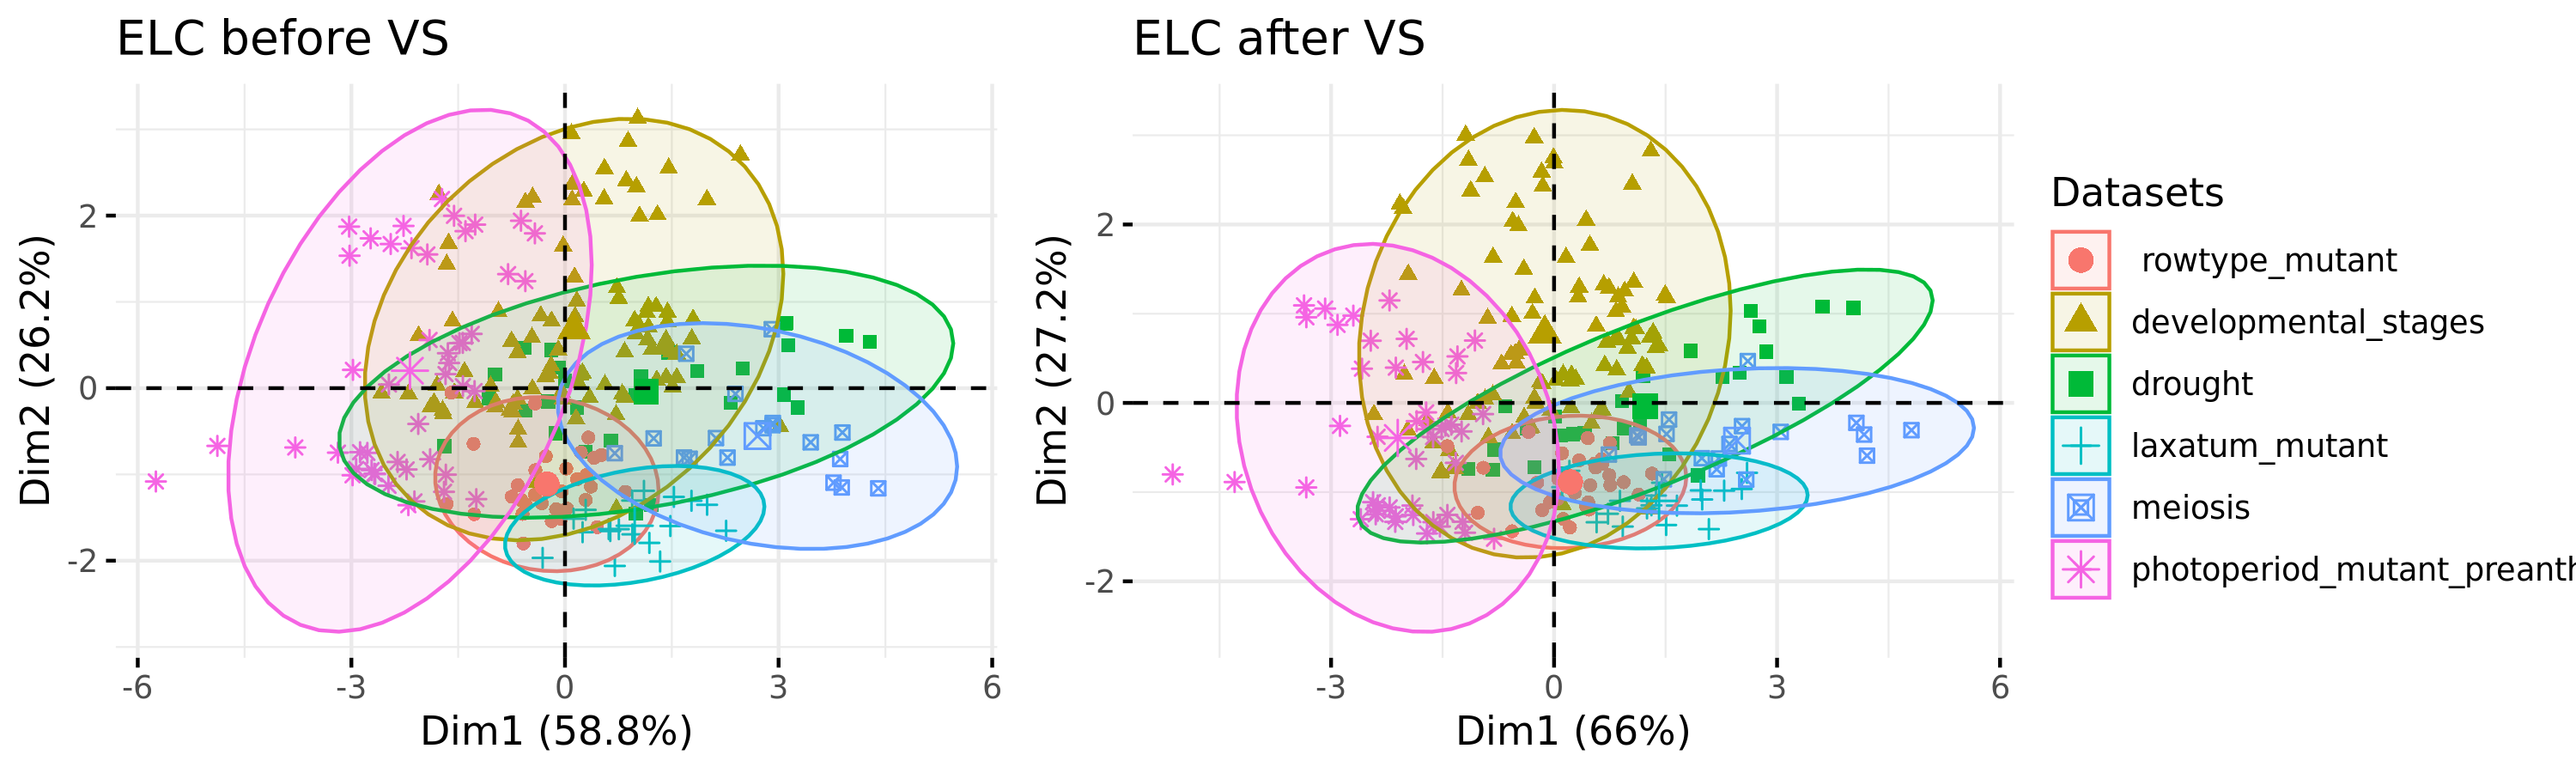

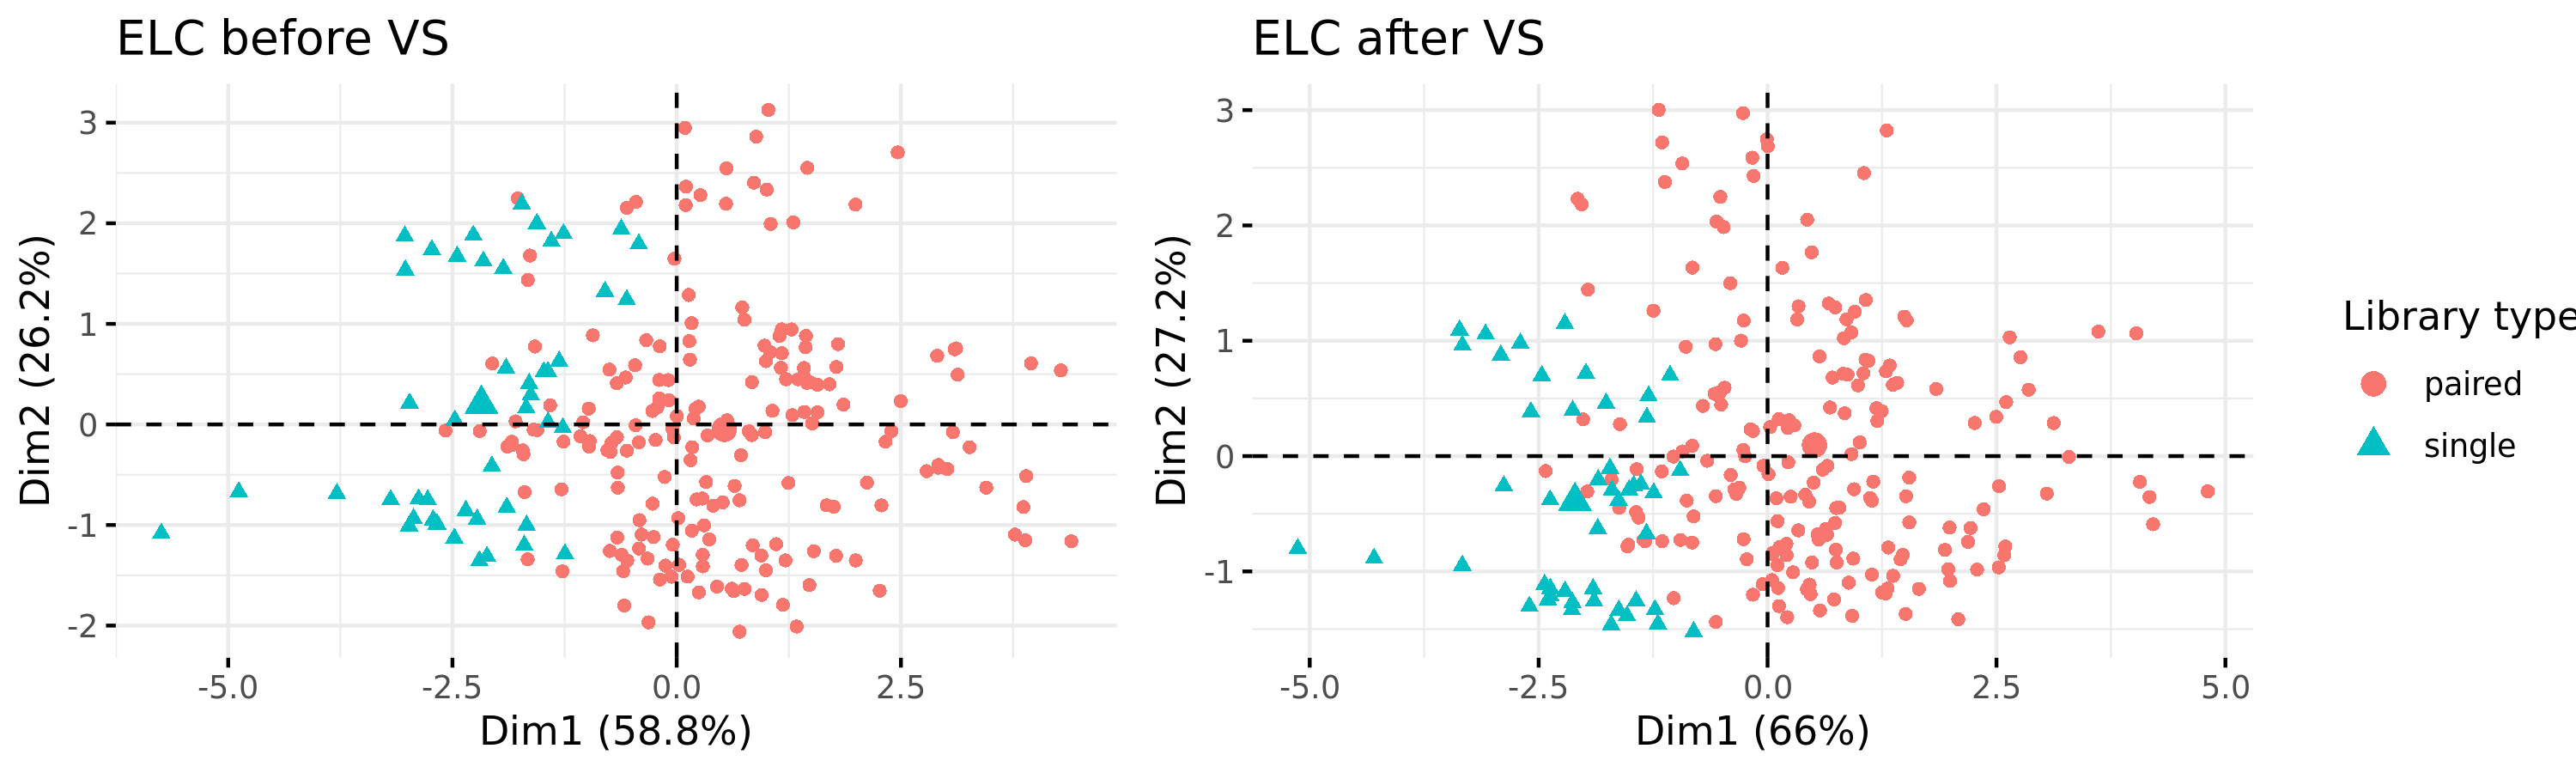

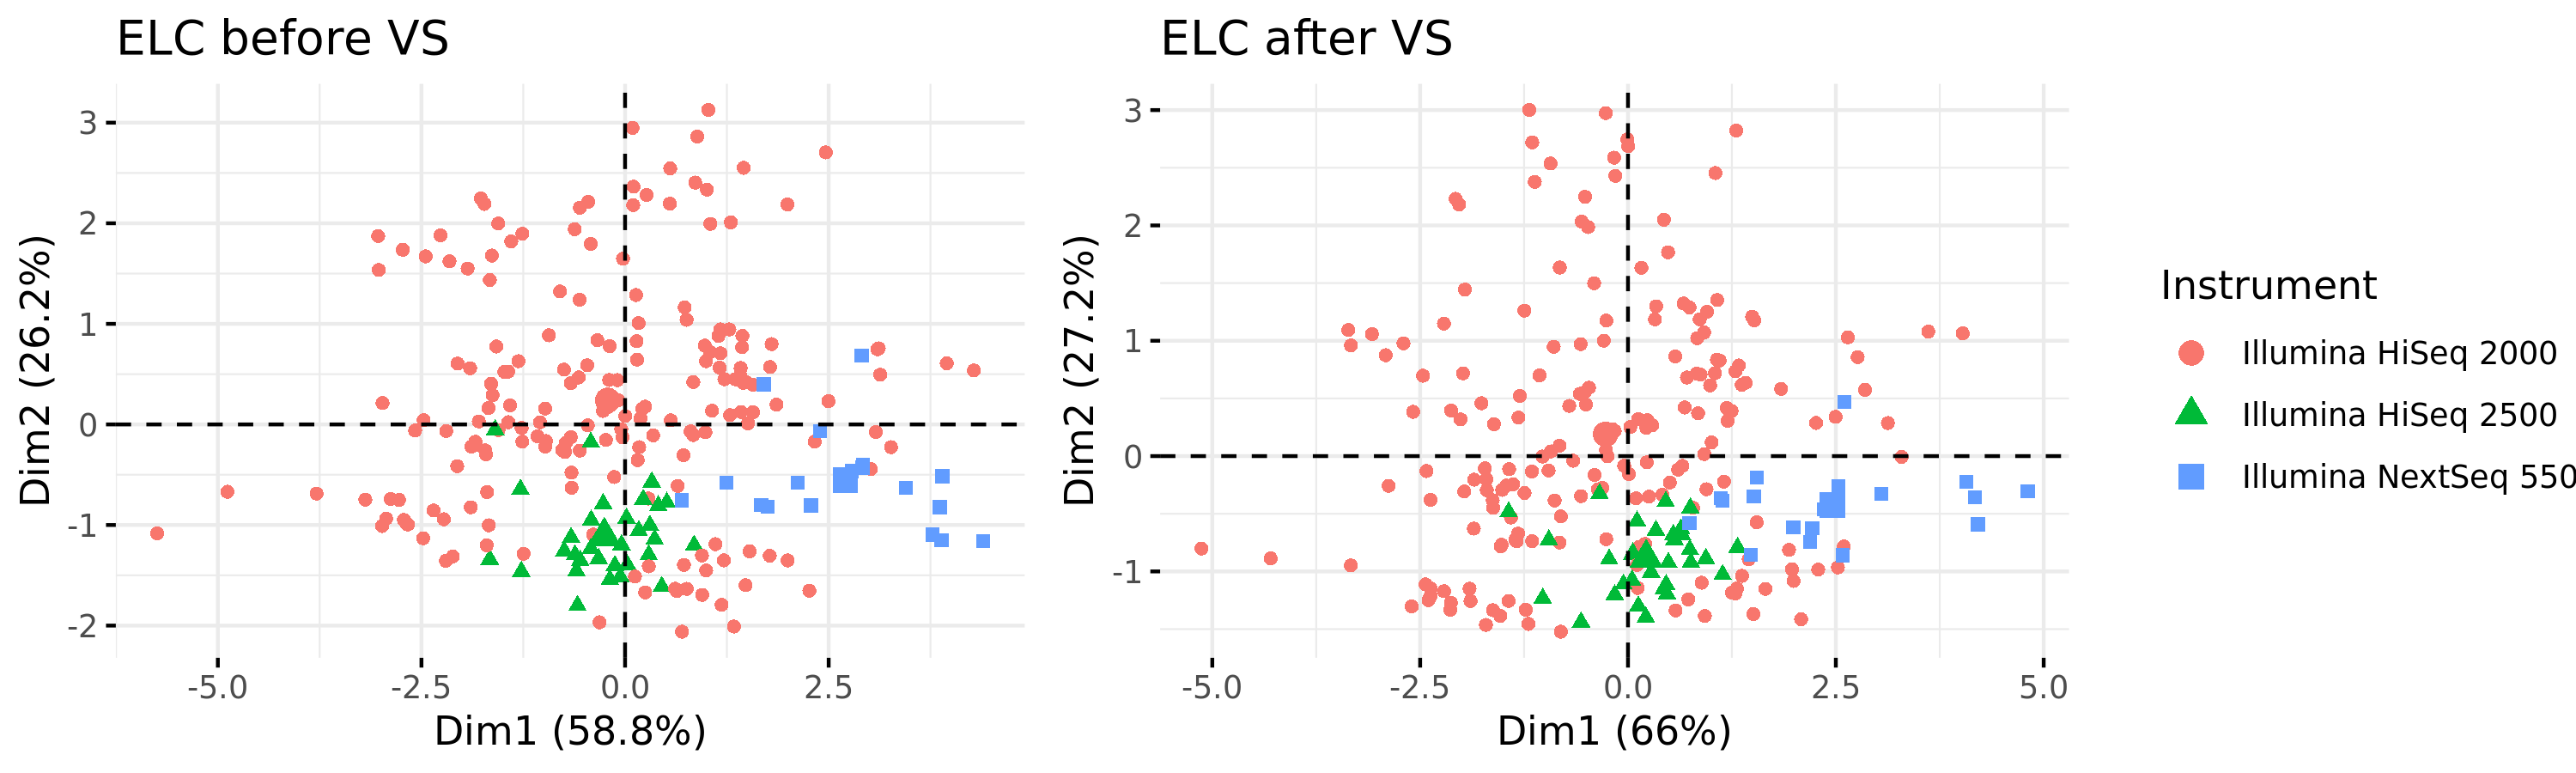

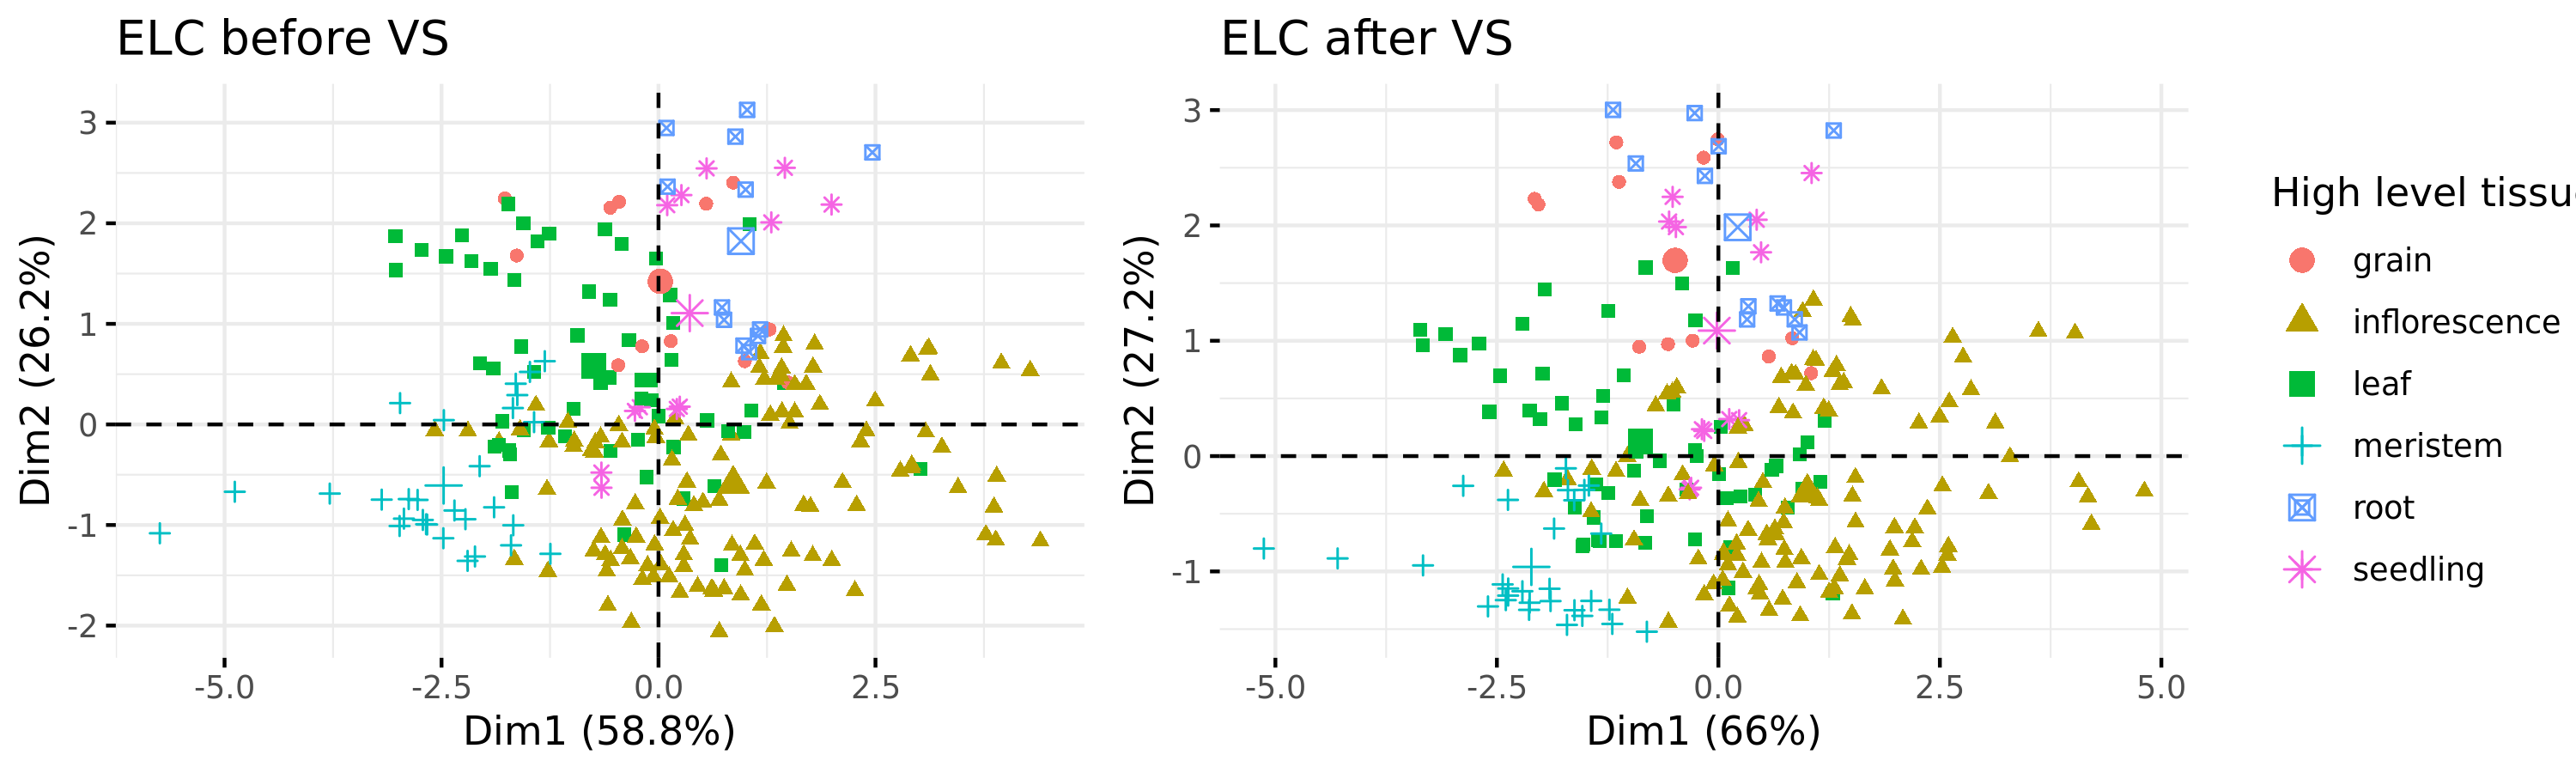

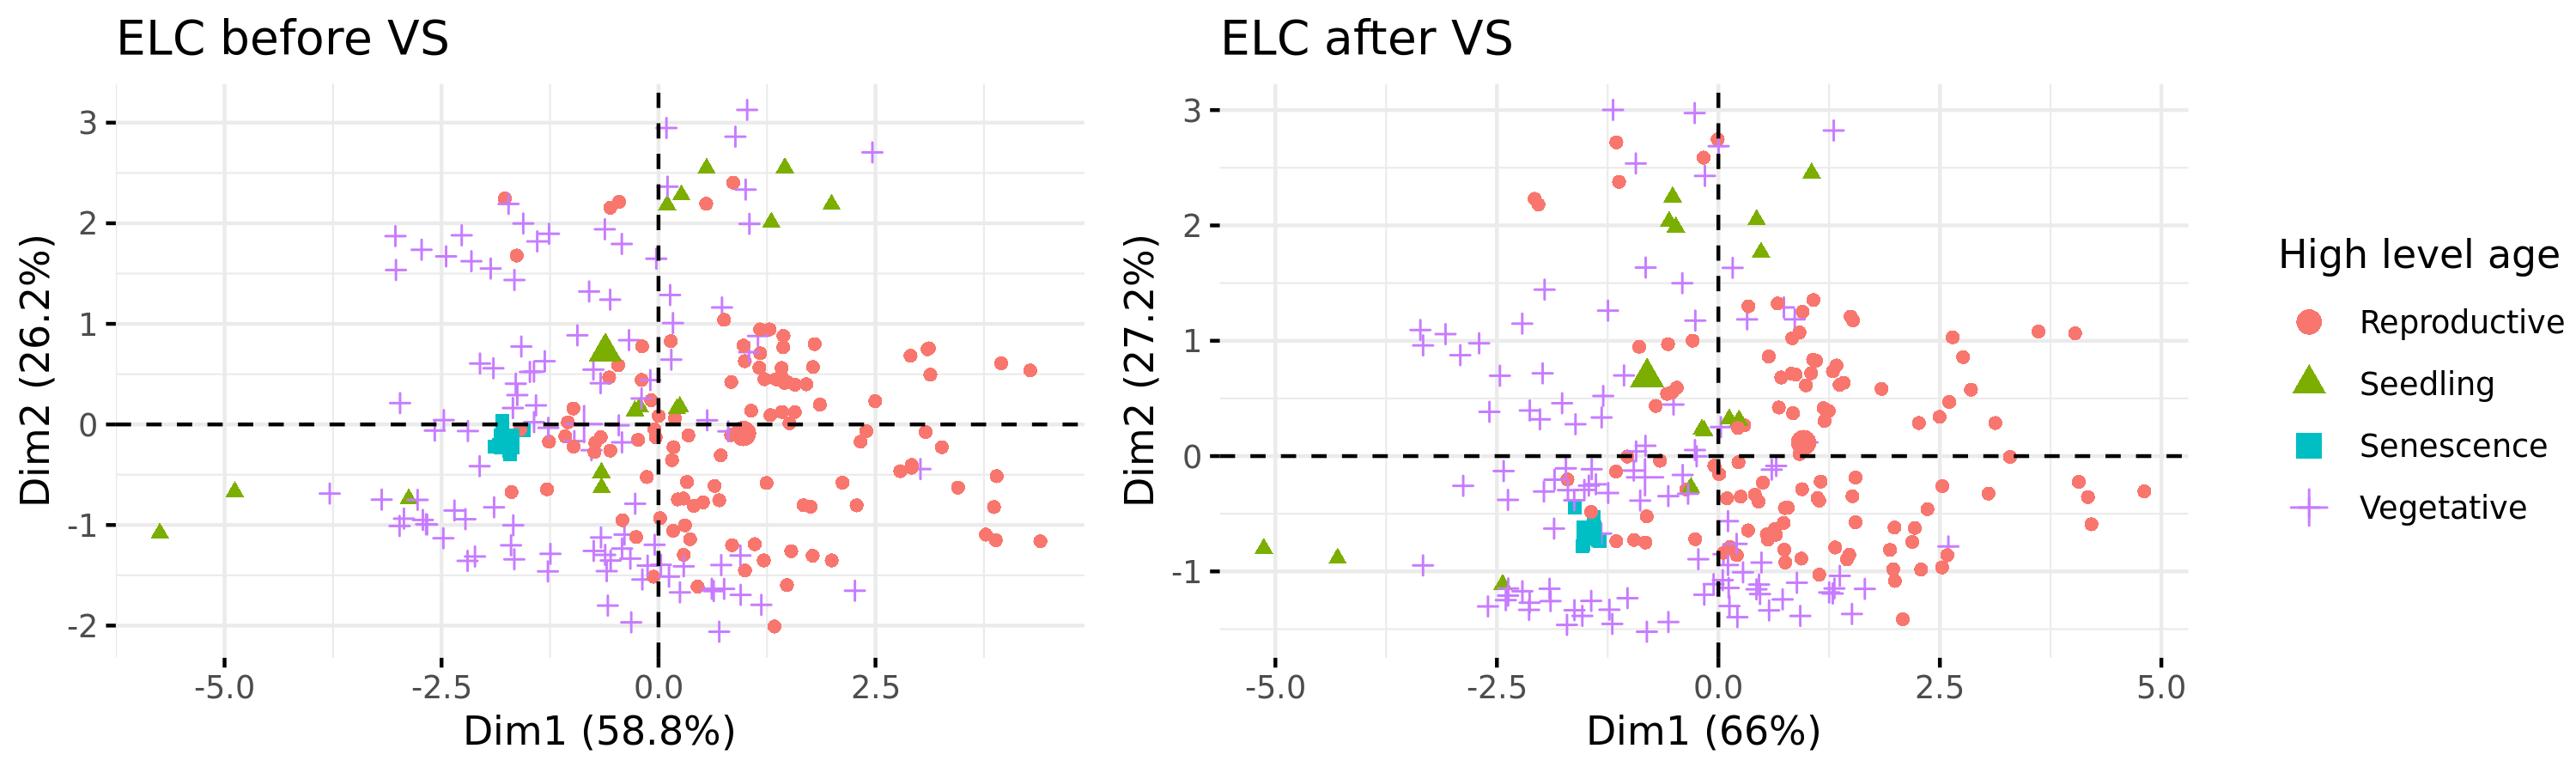

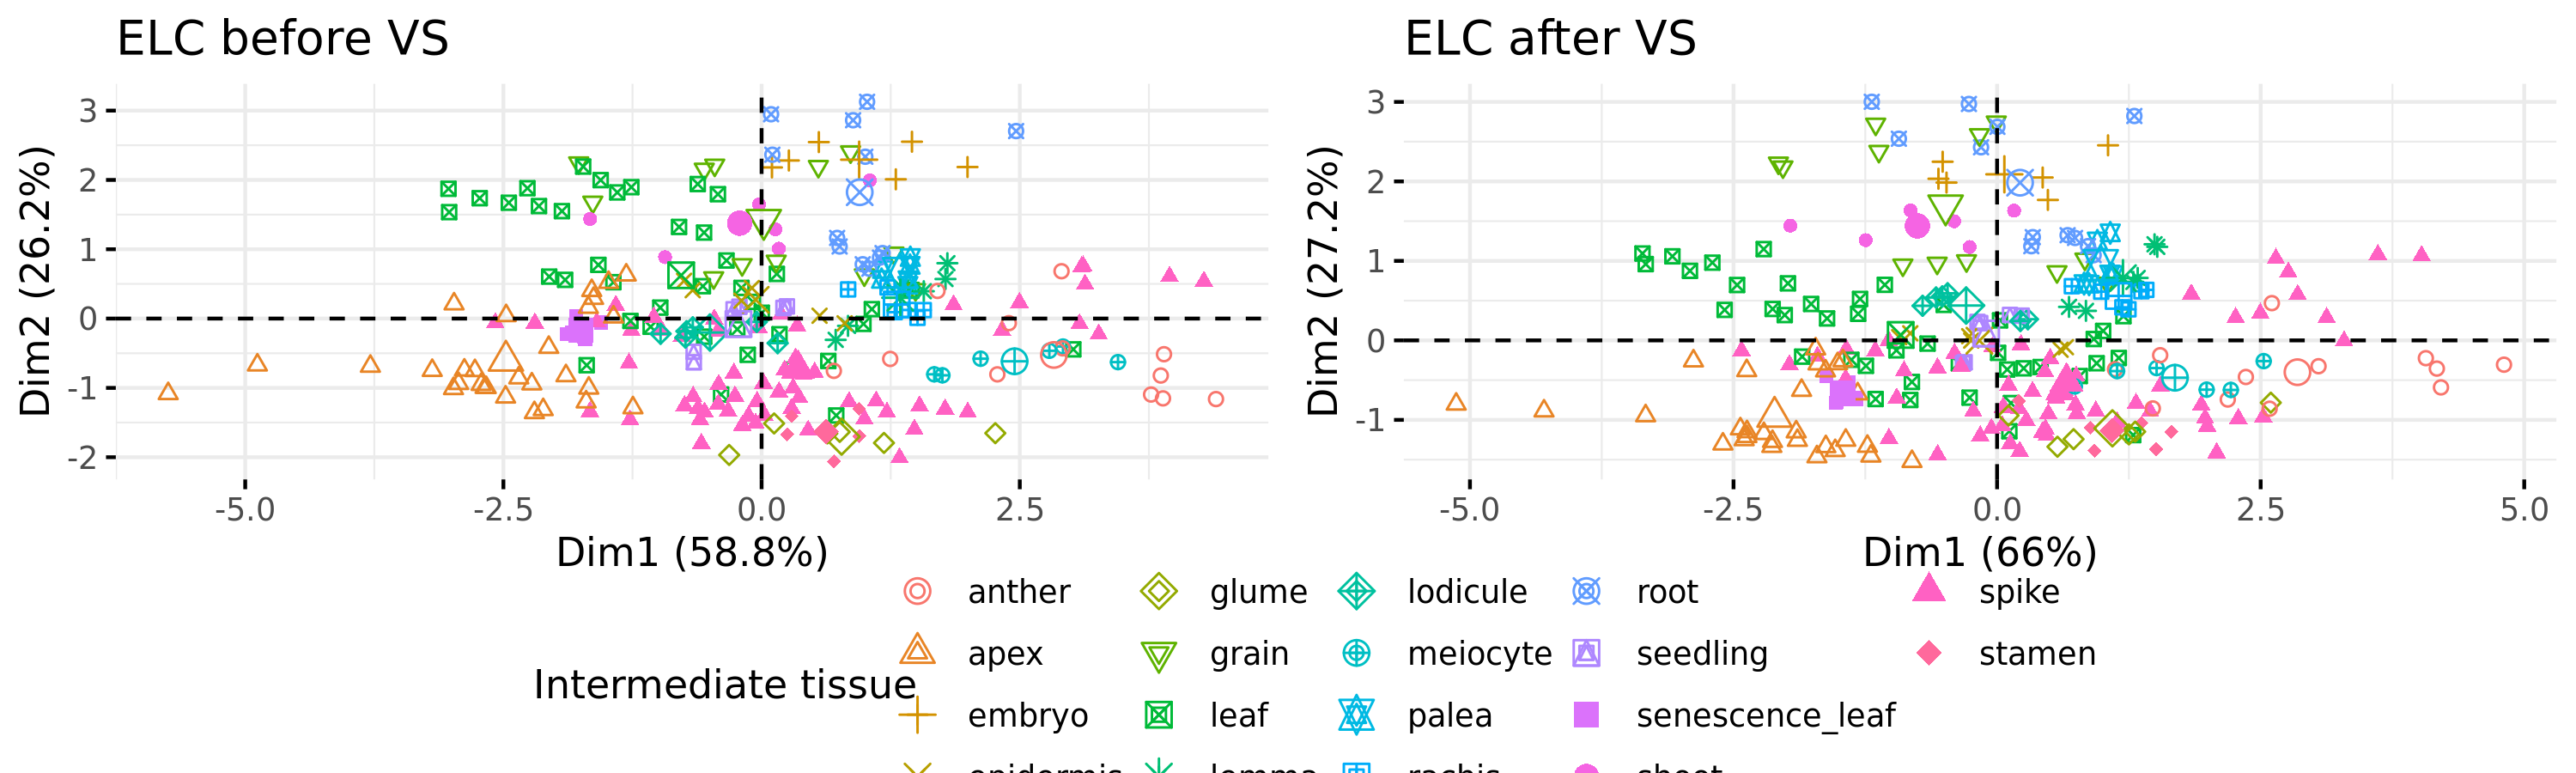

In [32]:
cowplot::plot_grid(prow1, legend1, rel_widths = c(3, .8))
cowplot::plot_grid(prow2, legend2, rel_widths = c(3, .4))
cowplot::plot_grid(prow3, legend3, rel_widths = c(3, .7))
cowplot::plot_grid(prow4, legend4, rel_widths = c(3, .5))
cowplot::plot_grid(prow5, legend5, rel_widths = c(3, .5))
cowplot::plot_grid(prow6, legend6, ncol = 1, rel_heights = c(1, .3))

# 4. Calculating expression bias
* dividing the # of E4 samples with library size

In [19]:
head(h)
d <- as.data.frame(h)
#d$locus <- row.names(d)
locus <- rownames(d)
rownames(d) <- NULL
d <- cbind(locus,d)
head(d)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 452.0000  388.0000  405.0000  359.0000   657.000  ⋯
Horvu_MOREX_1H01G000200   1.0000    1.0000    0.0000    0.0000     1.000  ⋯
Horvu_MOREX_1H01G000300 163.0000  160.0000  133.0000  117.0000   284.000  ⋯
Horvu_MOREX_1H01G000400 657.0000  577.0000  605.0000  540.0000  1183.000  ⋯
Horvu_MOREX_1H01G000500 635.0000  772.0000  607.0000  630.0000  1166.000  ⋯
Horvu_MOREX_1H01G000600 776.8168  827.0809  874.5452  566.1862  1397.799  ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 1232.000  2237.000  1503.000  1833.000  1695.000 
Horvu_MOREX_1H01G000200    1.000     3.000    10.000     1.000     2.000 
Horvu_MOREX_1H01G000300  428.000   610.000   519.000   466.000   492.000 
Horvu_MOREX_1H01G000400  971.000  1640.000  1312.000  1160.000  2093.000 
Horvu_MOREX_1H01G000500 3656.000  4336.000  4734.000  4469.000  2296.000 
Horvu_MOREX_1H01G000600 2808.661  3316.393  2766.549  2833.275  2984.255 
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 2477.000  2265.000  2578.000  2468.000  2317.000 
Horvu_MOREX_1H01G000200    8.000     6.000     0.000     2.000     2.000 
Horvu_MOREX_1H01G000300  652.000   569.000   677.000   710.000   584.000 
Horvu_MOREX_1H01G000400 2738.000  2795.000  3687.000  3044.000  3045.000 
Horvu_MOREX_1H01G000500 2418.000  2349.000  3908.000  3340.000  3221.000 
Horvu_MOREX_1H01G000600 4250.868  3915.629  4172.974  4106.843  4045.146

locus                   ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
1 Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
2 Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
3 Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
4 Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
5 Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
6 Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
  ERR781044 ERR781045 ERR781046 ERR781047 ⋯ ERR515188 ERR515189 ERR515190
1 452.0000  388.0000  405.0000  359.0000  ⋯ 1232.000  2237.000  1503.000 
2   1.0000    1.0000    0.0000    0.0000  ⋯    1.000     3.000    10.000 
3 163.0000  160.0000  133.0000  117.0000  ⋯  428.000   610.000   519.000 
4 657.0000  577.0000  605.0000  540.0000  ⋯  971.000  1640.000  1312.000 
5 635.0000  772.0000  607.0000  630.0000  ⋯ 3656.000  4336.000  4734.000 
6 776.8168  827.0809  874.5452  566.1862  ⋯ 2808.661  3316.393  2766.549 
  ERR515191 ERR515192 ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
1 1833.000  1695.000  2477.000  2265.000  2578.000  2468.000  2317.000 
2    1.000     2.000     8.000     6.000     0.000     2.000     2.000 
3  466.000   492.000   652.000   569.000   677.000   710.000   584.000 
4 1160.000  2093.000  2738.000  2795.000  3687.000  3044.000  3045.000 
5 4469.000  2296.000  2418.000  2349.000  3908.000  3340.000  3221.000 
6 2833.275  2984.255  4250.868  3915.629  4172.974  4106.843  4045.146

In [20]:
m=as.data.table(d)
m=melt(m,id.vars=c("locus"),variable.name="sample_id",value.name="tpm")
setkey(m,locus,sample_id)
head(m)

locus                   sample_id tpm
1 Horvu_MOREX_1H01G000100 ERR781039 336
2 Horvu_MOREX_1H01G000100 ERR781040 122
3 Horvu_MOREX_1H01G000100 ERR781041  66
4 Horvu_MOREX_1H01G000100 ERR781042 208
5 Horvu_MOREX_1H01G000100 ERR781043 354
6 Horvu_MOREX_1H01G000100 ERR781044 452

In [21]:
tau<-function(x){
  if(any(is.na(x))) stop('NA\'s need to be 0.')
  if(any(x<0)) stop('Negative input values not permitted. Maybe data is log transformed?')
  t<-sum(1-x/max(x))/(length(x)-1)
} 

In [22]:
dm <- data.matrix(d, rownames.force = TRUE)
locus <- d$locus
row.names(dm) <- locus
dm <- dm[1:49281, 2:241]
head(dm)
tau=apply(dm,1,tau)
head(tau)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 452.0000  388.0000  405.0000  359.0000   657.000  ⋯
Horvu_MOREX_1H01G000200   1.0000    1.0000    0.0000    0.0000     1.000  ⋯
Horvu_MOREX_1H01G000300 163.0000  160.0000  133.0000  117.0000   284.000  ⋯
Horvu_MOREX_1H01G000400 657.0000  577.0000  605.0000  540.0000  1183.000  ⋯
Horvu_MOREX_1H01G000500 635.0000  772.0000  607.0000  630.0000  1166.000  ⋯
Horvu_MOREX_1H01G000600 776.8168  827.0809  874.5452  566.1862  1397.799  ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 1232.000  2237.000  1503.000  1833.000  1695.000 
Horvu_MOREX_1H01G000200    1.000     3.000    10.000     1.000     2.000 
Horvu_MOREX_1H01G000300  428.000   610.000   519.000   466.000   492.000 
Horvu_MOREX_1H01G000400  971.000  1640.000  1312.000  1160.000  2093.000 
Horvu_MOREX_1H01G000500 3656.000  4336.000  4734.000  4469.000  2296.000 
Horvu_MOREX_1H01G000600 2808.661  3316.393  2766.549  2833.275  2984.255 
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 2477.000  2265.000  2578.000  2468.000  2317.000 
Horvu_MOREX_1H01G000200    8.000     6.000     0.000     2.000     2.000 
Horvu_MOREX_1H01G000300  652.000   569.000   677.000   710.000   584.000 
Horvu_MOREX_1H01G000400 2738.000  2795.000  3687.000  3044.000  3045.000 
Horvu_MOREX_1H01G000500 2418.000  2349.000  3908.000  3340.000  3221.000 
Horvu_MOREX_1H01G000600 4250.868  3915.629  4172.974  4106.843  4045.146

Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200 Horvu_MOREX_1H01G000300 
              0.8718497               0.9356756               0.8612974 
Horvu_MOREX_1H01G000400 Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600 
              0.8704856               0.8296467               0.7123973

In [23]:
Mall = m[,list(sample=sample_id, tpm=tpm, min_tpm=min(tpm,na.rm=TRUE),median_tpm=median(tpm,na.rm=TRUE),max_tpm=max(tpm,na.rm=TRUE),breadth=length(tpm[tpm>non.expr.cutoff])/length(tpm)),by=list(locus)]
Mall = data.table(sample=Mall$sample, locus=Mall$locus, tpm=Mall$tpm, min_tpm=Mall$min_tpm, median_tpm=Mall$median_tpm, max_tpm=Mall$max_tpm, breadth=Mall$breadth)
setkey(Mall,sample)
head(Mall)

sample    locus                   tpm      min_tpm median_tpm max_tpm  
1 ERR781039 Horvu_MOREX_1H01G000100 336.0000  66     1218.0000   9724.000
2 ERR781039 Horvu_MOREX_1H01G000200   1.0000   0        6.0000   2230.000
3 ERR781039 Horvu_MOREX_1H01G000300 116.0000  17      258.0000   2775.000
4 ERR781039 Horvu_MOREX_1H01G000400 550.0000  16      502.0000   6124.000
5 ERR781039 Horvu_MOREX_1H01G000500 556.0000 116     1538.0000  11441.000
6 ERR781039 Horvu_MOREX_1H01G000600 707.3084  38      793.8853   4267.252
  breadth  
1 1.0000000
2 0.8083333
3 1.0000000
4 1.0000000
5 1.0000000
6 1.0000000

In [24]:
tau=as.data.table(data.frame(locus=names(tau),tau=tau))
setkey(tau,locus)
head(tau)

locus                   tau      
1 Horvu_MOREX_1H01G000100 0.8718497
2 Horvu_MOREX_1H01G000200 0.9356756
3 Horvu_MOREX_1H01G000300 0.8612974
4 Horvu_MOREX_1H01G000400 0.8704856
5 Horvu_MOREX_1H01G000500 0.8296467
6 Horvu_MOREX_1H01G000600 0.7123973

In [25]:
Mall=merge(Mall,tau, by = "locus")
setkey(Mall, locus)
head(Mall)
nrow(Mall)

locus                   sample    tpm min_tpm median_tpm max_tpm breadth
1 Horvu_MOREX_1H01G000100 ERR781039 336 66      1218       9724    1      
2 Horvu_MOREX_1H01G000100 ERR781040 122 66      1218       9724    1      
3 Horvu_MOREX_1H01G000100 ERR781041  66 66      1218       9724    1      
4 Horvu_MOREX_1H01G000100 ERR781042 208 66      1218       9724    1      
5 Horvu_MOREX_1H01G000100 ERR781043 354 66      1218       9724    1      
6 Horvu_MOREX_1H01G000100 ERR781044 452 66      1218       9724    1      
  tau      
1 0.8718497
2 0.8718497
3 0.8718497
4 0.8718497
5 0.8718497
6 0.8718497

[1] 11827440

In [26]:
get_elc=function(cut,f,n) {
    s=Mall
    sx=s[s[[f]]>cut]
    k=kmeans(log(sx[,f,with=FALSE]+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[s[[f]]>cut]=kk
    so=data.frame(o=so)
    names(so)[ncol(so)]=gsub("tpm","elc",n)
    so=as.data.table(so)
    so
}

In [27]:
MO=foreach(i=3:6,.combine="cbind") %do% {
    get_elc(non.expr.cutoff,i,names(Mall)[i])
}
MO=cbind(Mall,MO)
setkey(MO,sample)

In [28]:
MO[,blc:=cut(breadth,breaks=seq(0,1,0.2,),include.lowest=TRUE,ordered.result=TRUE,labels=c("very few","few","medium","many","most")),by=list(locus)] 

In [29]:
head(MO) 

locus                   sample    tpm      min_tpm median_tpm max_tpm  
1 Horvu_MOREX_1H01G000100 ERR781039 336.0000  66     1218.0000   9724.000
2 Horvu_MOREX_1H01G000200 ERR781039   1.0000   0        6.0000   2230.000
3 Horvu_MOREX_1H01G000300 ERR781039 116.0000  17      258.0000   2775.000
4 Horvu_MOREX_1H01G000400 ERR781039 550.0000  16      502.0000   6124.000
5 Horvu_MOREX_1H01G000500 ERR781039 556.0000 116     1538.0000  11441.000
6 Horvu_MOREX_1H01G000600 ERR781039 707.3084  38      793.8853   4267.252
  breadth   tau       elc min_elc median_elc max_elc blc 
1 1.0000000 0.8718497 E3  E3      E4         E4      most
2 0.8083333 0.9356756 E1  E0      E1         E3      most
3 1.0000000 0.8612974 E3  E2      E3         E3      most
4 1.0000000 0.8704856 E3  E2      E4         E4      most
5 1.0000000 0.8296467 E3  E4      E4         E4      most
6 1.0000000 0.7123973 E4  E3      E4         E4      most

In [30]:
bias <- select(MO, locus, sample, tpm, elc)
glimpse(bias)

Rows: 11,827,440
Columns: 4
$ locus  <fct> Horvu_MOREX_1H01G000100, Horvu_MOREX_1H01G000200, Horvu_MOREX_…
$ sample <fct> ERR781039, ERR781039, ERR781039, ERR781039, ERR781039, ERR7810…
$ tpm    <dbl> 336.00000, 1.00000, 116.00000, 550.00000, 556.00000, 707.30838…
$ elc    <ord> E3, E1, E3, E3, E3, E4, E3, E3, E2, E3, E3, E0, E0, E0, E0, E0…


In [31]:
bias_sum <- bias %>% filter(elc == "E4") %>%
        group_by(sample) %>%
        summarise(E4_tpm_sum = sum(tpm))
#bias_sum$E4_tpm_sum <- as.integer(bias_sum$E4_tpm_sum)
#bias_sum$sample <- as.character(bias_sum$sample)


lib_size <- bias %>% group_by(sample) %>%
        summarise(lib_size = sum(tpm))
#lib_size$lib_size <- as.integer(lib_size$lib_size)
#lib_size$sample <- as.character(lib_size$sample)

bias_lib <- inner_join(bias_sum, lib_size, by ="sample") 

setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
barley_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
barley_meta <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta) <- c("sample", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

bias_lib <- inner_join(bias_lib, barley_meta, by = "sample")
expr_bias <- bias_lib %>% mutate(bias = E4_tpm_sum/lib_size)
# next lines were made for boxplot display
#expr_bias <- bias_lib %>% mutate(bias = ((E4_tpm_sum/lib_size)*100))
#expr_bias$bias <- as.integer(expr_bias$bias)

glimpse(bias_sum)
glimpse(lib_size)
glimpse(expr_bias)

Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”

Rows: 240
Columns: 2
$ sample     <fct> ERR781039, ERR781040, ERR781041, ERR781042, ERR781043, ERR…
$ E4_tpm_sum <dbl> 6564143.7, 1345690.2, 699648.6, 3154486.2, 5168017.6, 7479…
Rows: 240
Columns: 2
$ sample   <fct> ERR781039, ERR781040, ERR781041, ERR781042, ERR781043, ERR78…
$ lib_size <dbl> 8923120, 2996946, 1943705, 5238143, 7523929, 9815584, 931302…
Rows: 240
Columns: 25
$ sample              <chr> "ERR781039", "ERR781040", "ERR781041", "ERR781042…
$ E4_tpm_sum          <dbl> 6564143.7, 1345690.2, 699648.6, 3154486.2, 516801…
$ lib_size            <dbl> 8923120, 2996946, 1943705, 5238143, 7523929, 9815…
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6…
$ cultivar            <chr> "S42-IL107", "S42-IL107", "S42-IL107", "Scarlett"…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
$ zadoc_scale         <int> 9, 9, 9, 11, 11, 11, 11, 11, 11, 14, 14

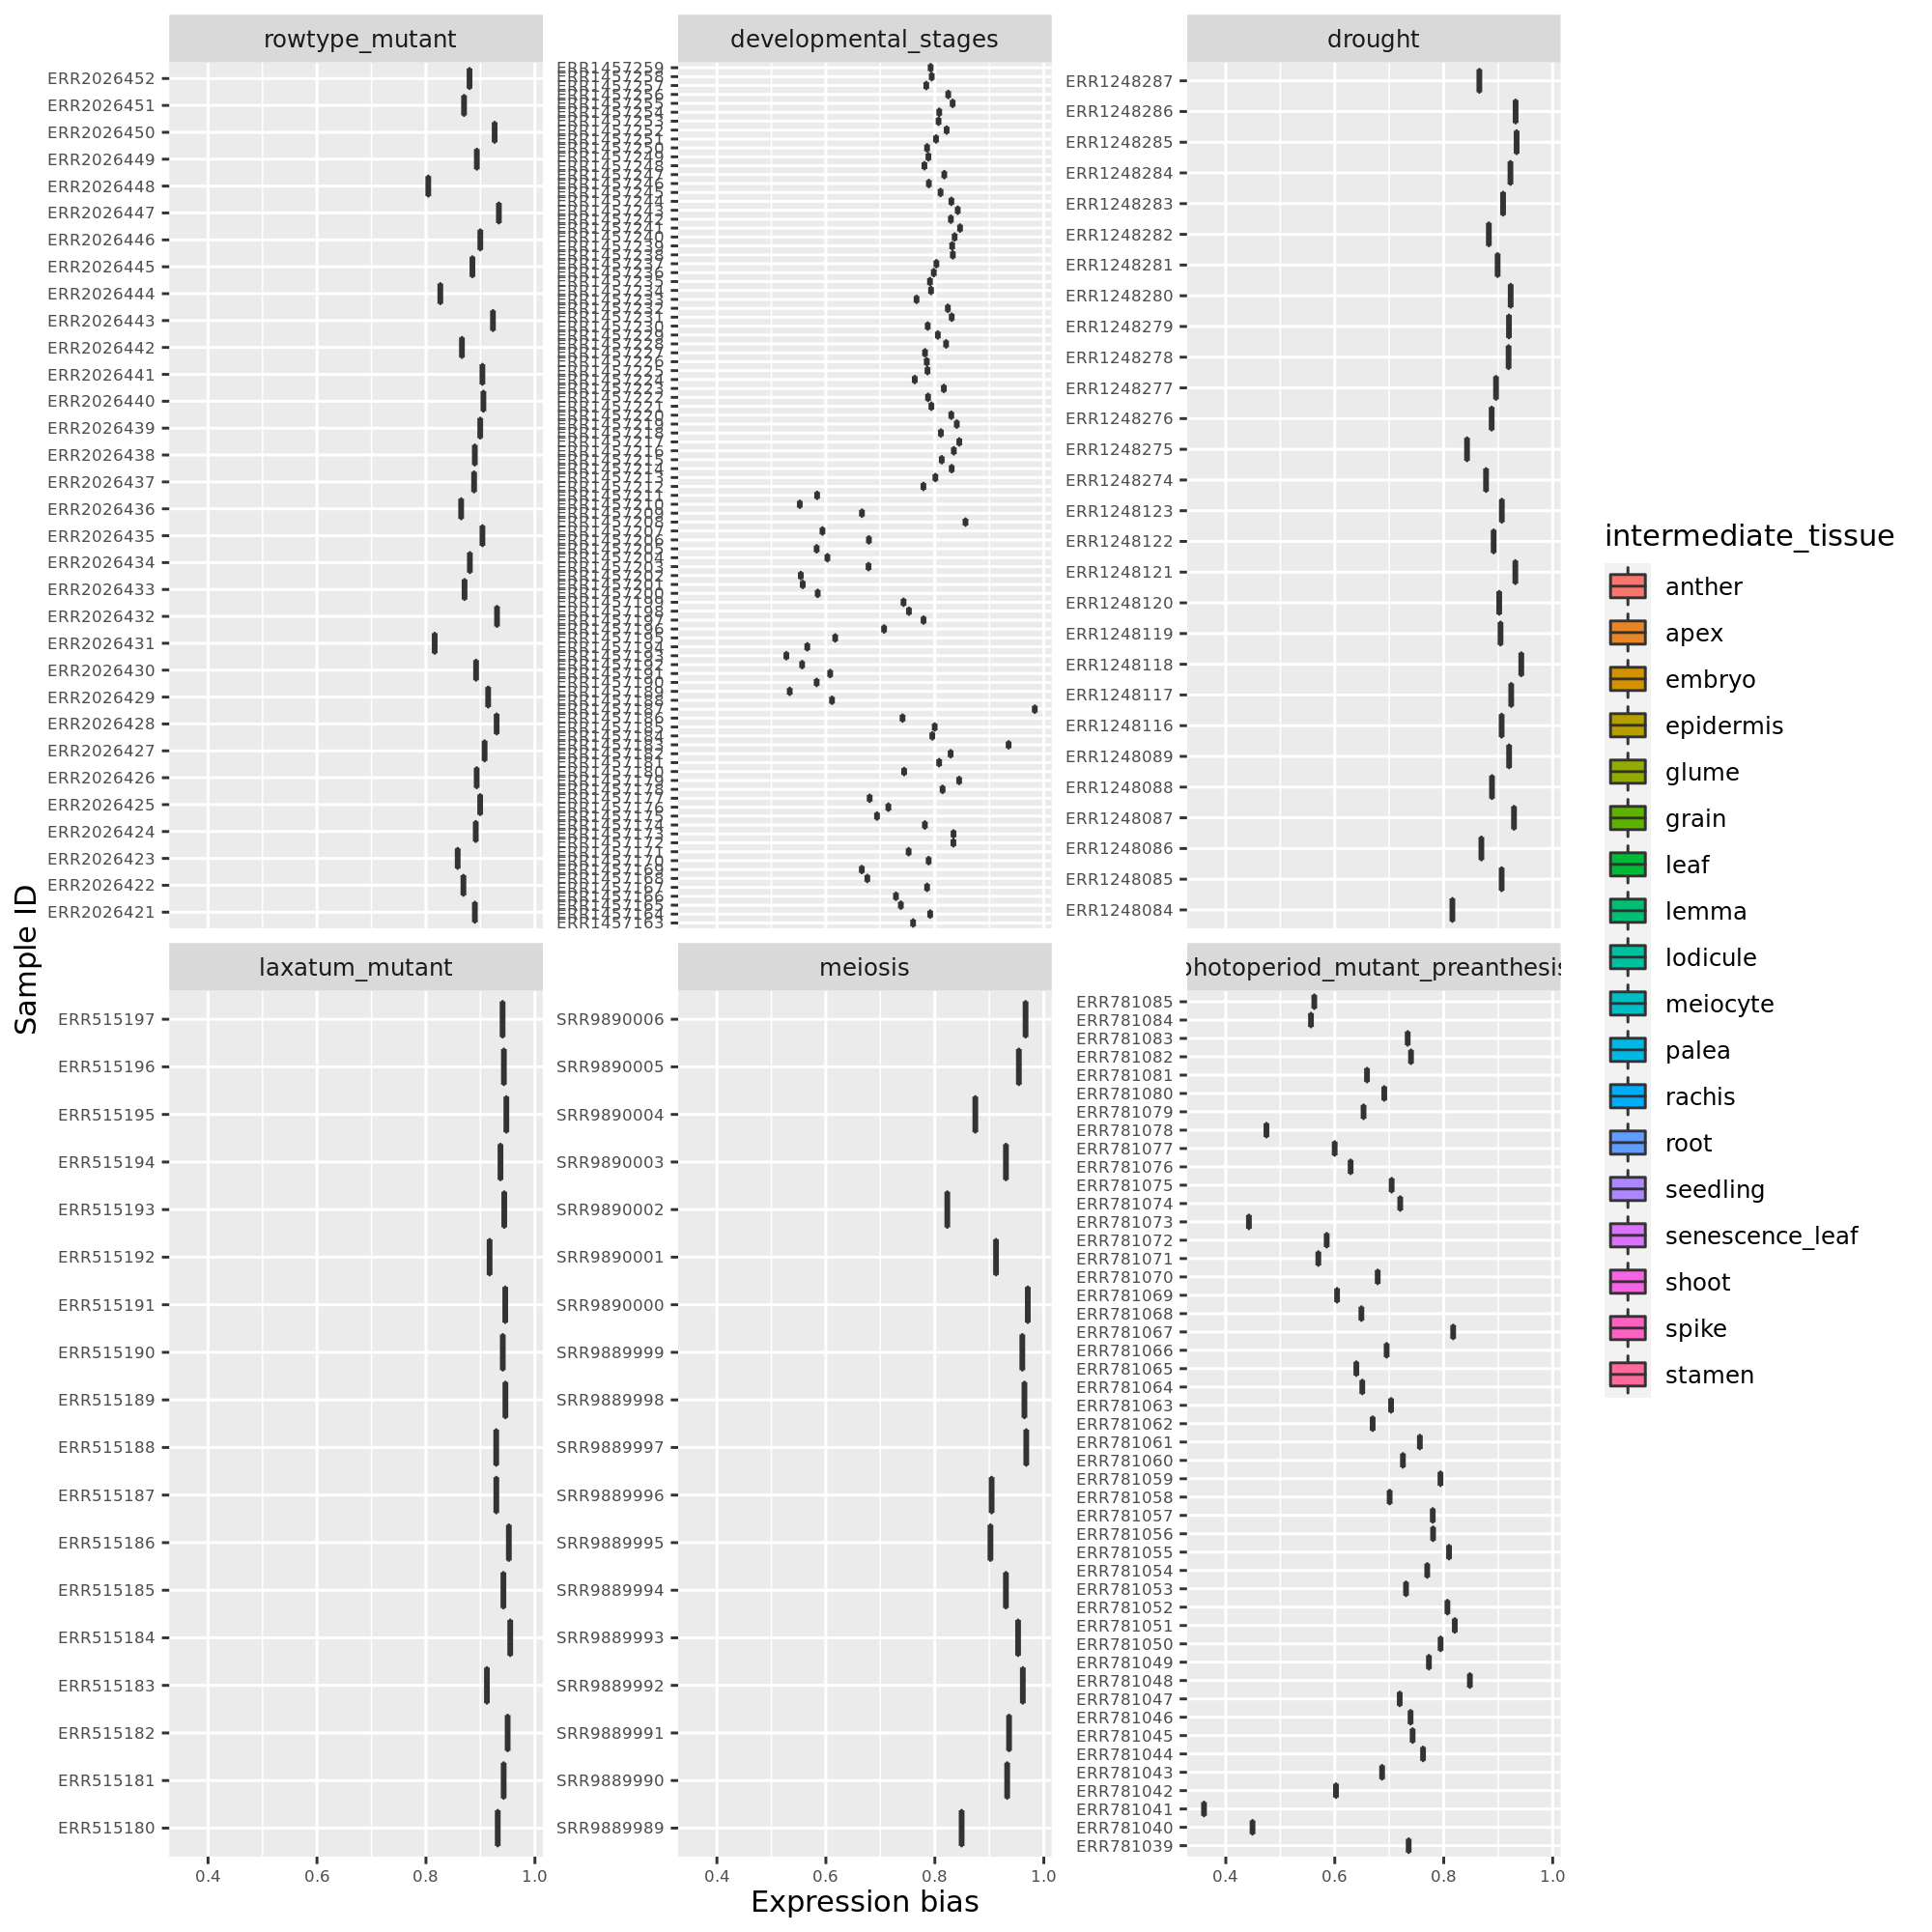

png 
  2

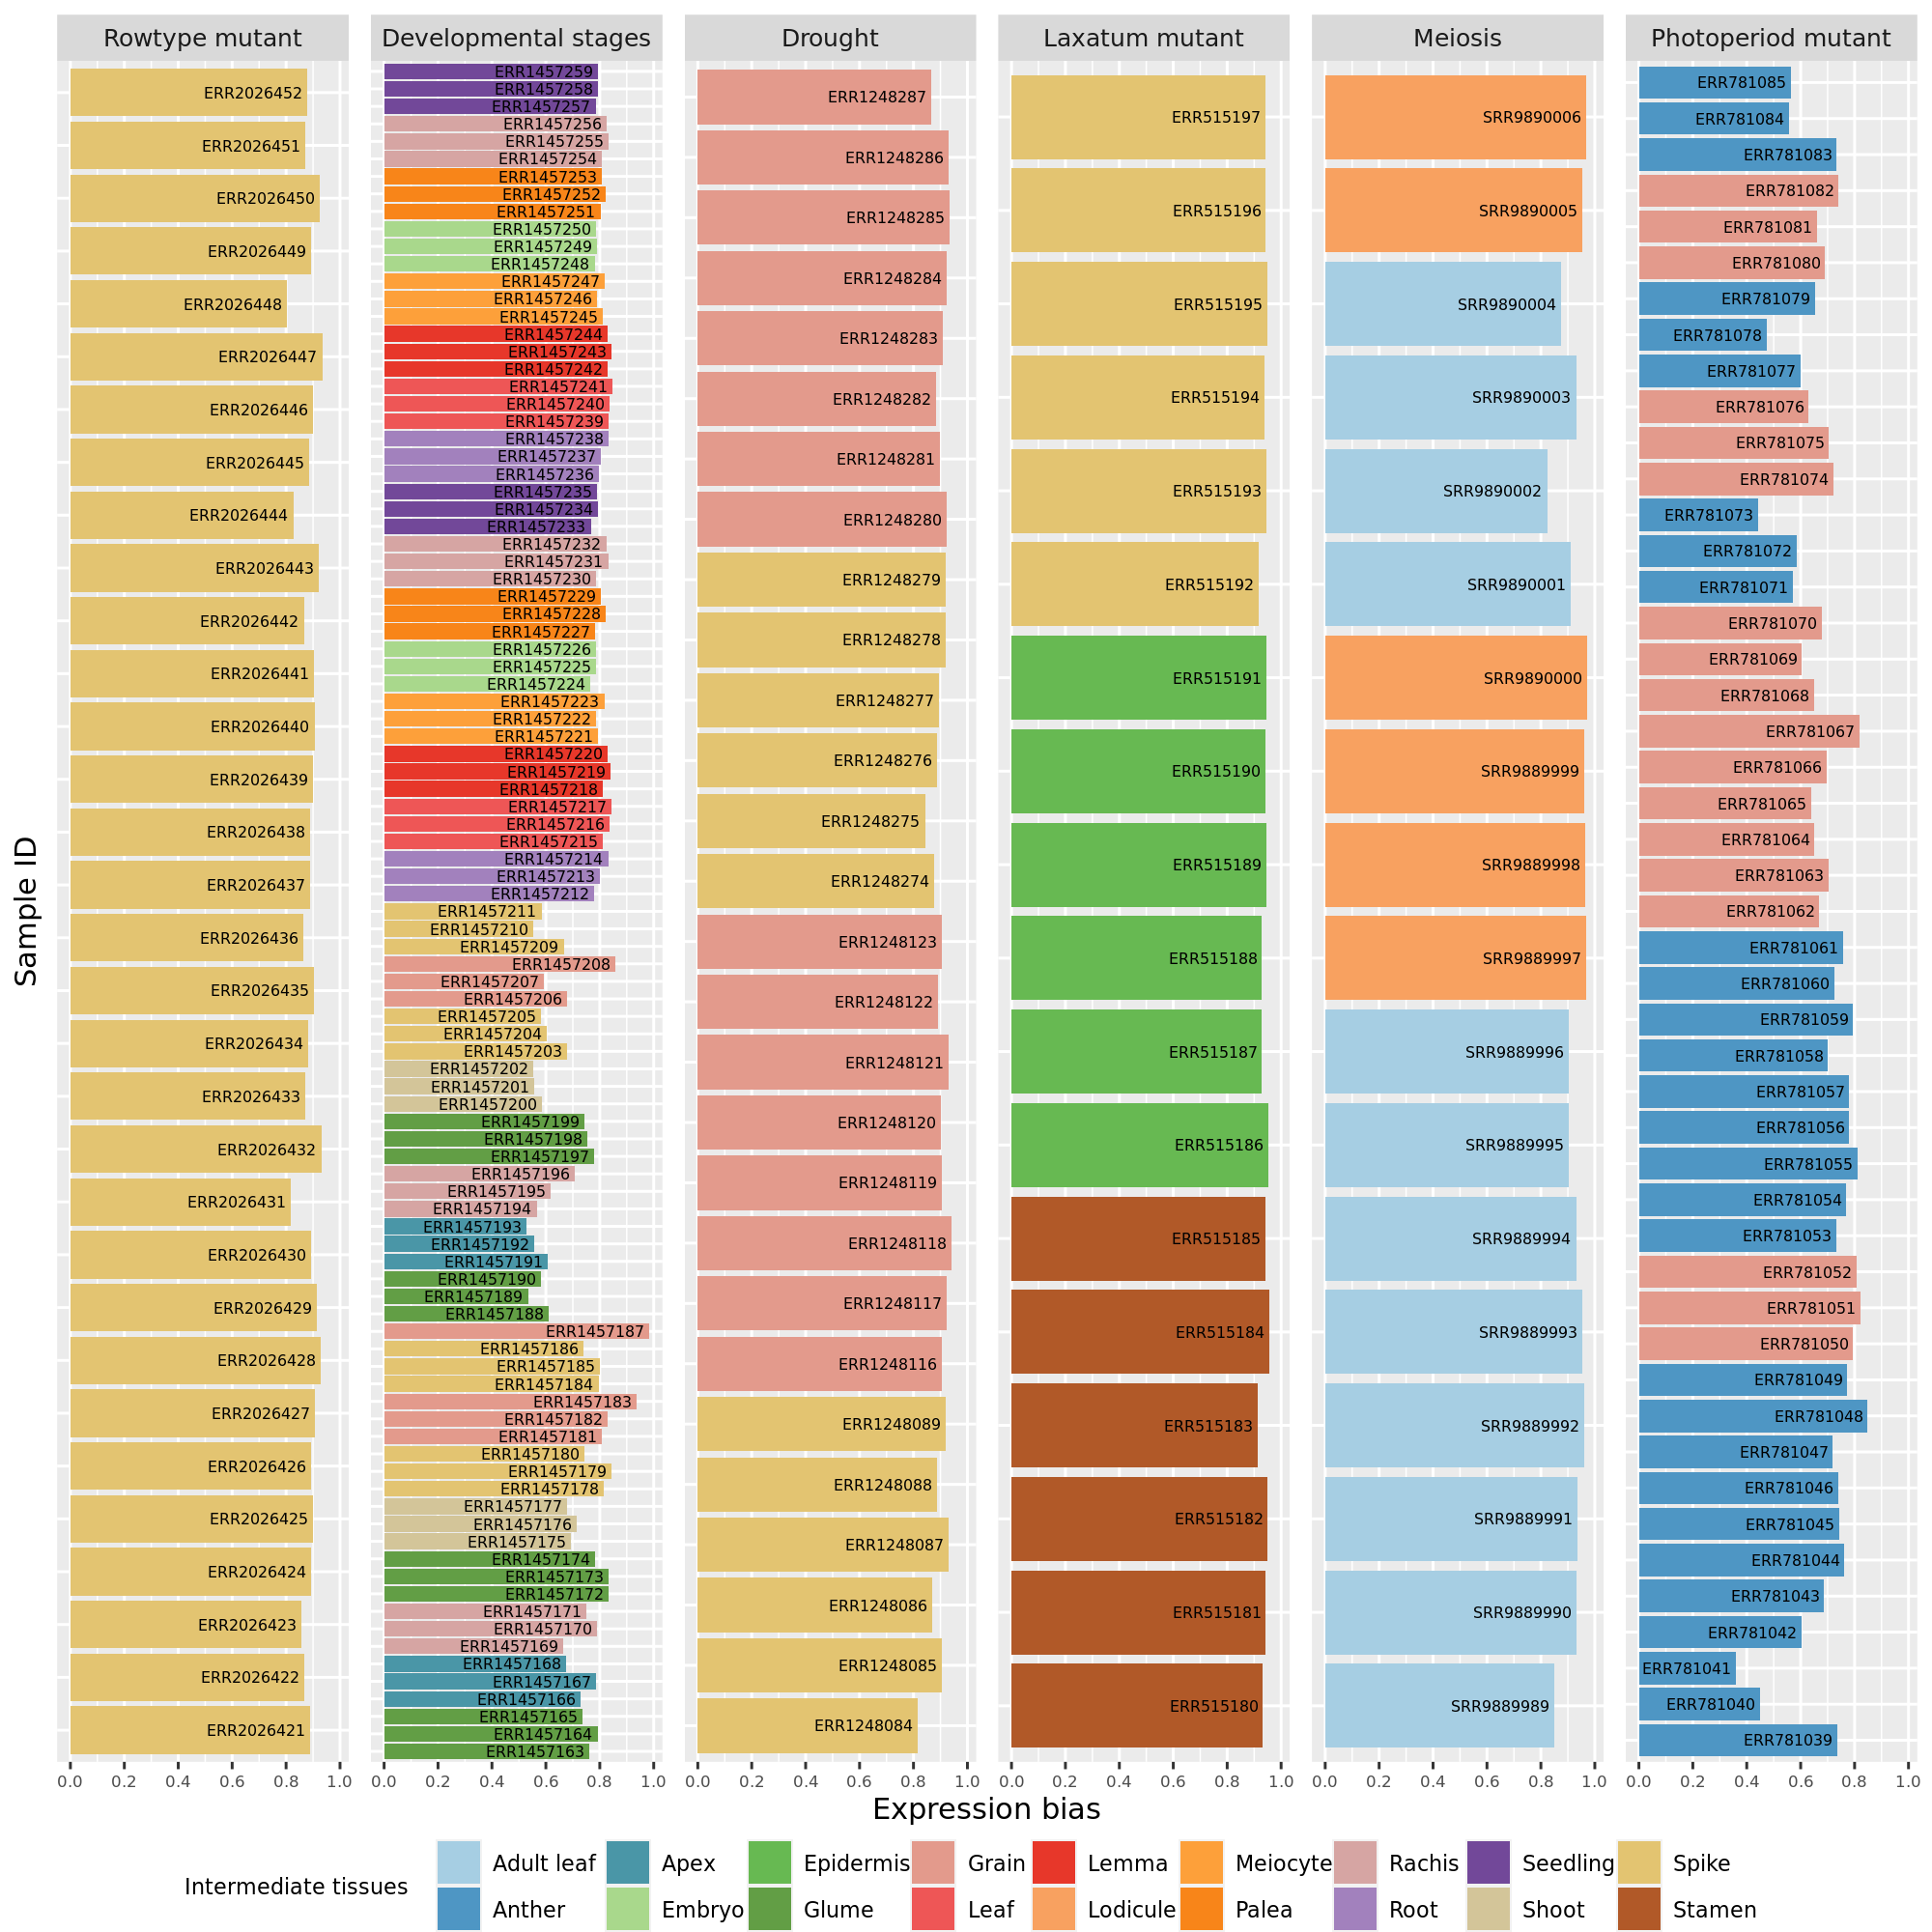

In [32]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

#boxplot is not possible for discrete values! 
#calculation had to be *100 to be able to convert it into integer
expr_bias %>%
    ggplot(aes(x = sample, y = bias, fill = intermediate_tissue)) +
    geom_boxplot() +
    coord_flip() +
    labs(x = "Sample ID", y = "Expression bias") +
    scale_y_continuous(breaks =c(0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
    facet_wrap( ~ dataset, scales= "free_y", ncol = 3) +
    theme(axis.text = element_text(size=6))

cols <- colorRampPalette(brewer.pal(12, "Paired"))
myPal <- cols(length(unique(expr_bias$intermediate_tissue)))

labs <- c("Rowtype mutant", "Developmental stages", "Drought", "Laxatum mutant", "Meiosis", "Photoperiod mutant")
names(labs) <- c(" rowtype_mutant", "developmental_stages", "drought", "laxatum_mutant", "meiosis", "photoperiod_mutant_preanthesis")

e1 <- expr_bias %>%
    ggplot(aes(x = sample, y = bias, fill = intermediate_tissue)) +
    geom_col() +
    coord_flip() +
    labs(x = "Sample ID", y = "Expression bias") +
    scale_y_continuous(breaks =c(0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
    facet_wrap( ~ dataset, labeller = labeller(dataset = labs), scales= "free_y", ncol = 6) +
    scale_fill_manual(values = myPal, name = "Intermediate tissues        ", labels = c("Adult leaf  ", "Anther", "Apex", "Embryo", "Epidermis", "Glume", "Grain", "Leaf", "Lemma", "Lodicule", "Meiocyte", "Palea", "Rachis", "Root", "Seedling", "Shoot", "Spike", "Stamen")) + 
    theme(axis.text.x = element_text(size = 6), 
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          strip.text.x = element_text(size = 9), legend.text=element_text(size=8)) +
    geom_text(aes(label = sample, hjust = 1.05), color = "black", size =2)
prow1 <- plot_grid(e1 + theme(legend.position="none"),
                   align = 'vh', hjust = 0, nrow = 1)
legend1 <- get_legend(e1 + guides(fill = guide_legend(nrow = 2)) + theme(legend.position = "bottom", legend.text=element_text(size=8), legend.title=element_text(size=8)))
a1 <- plot_grid(prow1, legend1, ncol = 1, rel_heights = c(1, .05))
a1
#axis.text.y = element_text(size = 0)

setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("elc_bias.png", units="in", width=10, height=10, res=300)
plot_grid(prow1, legend1, ncol = 1, rel_heights = c(1, .05))
dev.off()
ggsave("elc_bias_barley.pdf", plot =a1, width = 10, height = 10)

outlier samples: ERR781040 from the Photoperiod mutant dataset, and ERR1457187 from the developmental stages data-set needs to be excluded from further analysis.

In [33]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.26.0               SummarizedExperiment_1.16.0
 [3] DelayedArray_0.12.0         BiocParallel_1.20.0        
 [5] matrixStats_0.56.0          Biobase_2.46.0             
 [7] GenomicRanges_1.38.0        GenomeInfoDb_1.22.0        
 [9] IRanges_2.20.0          